In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [5]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [6]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

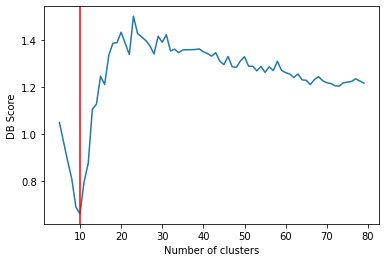

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

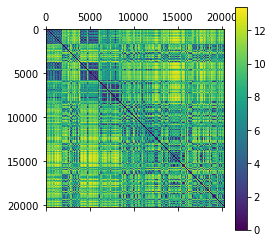

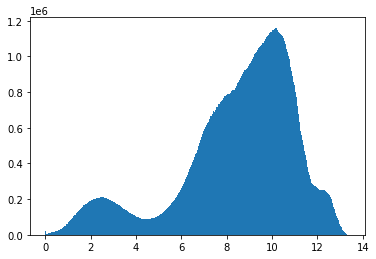

In [8]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

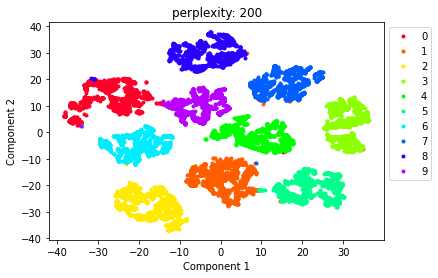

In [9]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [10]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [11]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [12]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [13]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [14]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9975360961908047


In [15]:
losses = []
accs = []
sparsity = []

In [16]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.08549167223200374
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.7726174033149171
layer 6: 0.587189226519337
layer 7: 0.4403919198895028
layer 8: 0.23564830801104975
layer 9: 0.11009797997237569
layer 10: 0.045391272444751385
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.303 | Reg loss: 0.021 | Tree loss: 2.303 | Accuracy: 0.091500 | 12.901 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.292 | Reg loss: 0.020 | Tree loss: 2.292 | Accuracy: 0.098500 | 13.064 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.283 | Reg loss: 0.020 | Tree loss: 2.283 | Accuracy: 0.168500 | 13.129 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.272 | Reg loss: 0.020 | Tree loss: 2.272 | Accuracy: 0.317000 | 12.033 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.264 | Reg loss: 0.019 | Tree loss: 2.264 | Accuracy: 0.354500 | 12.335 sec/iter
Epoch: 00 | Batch: 005 / 01

Epoch: 04 | Batch: 008 / 011 | Total loss: 2.195 | Reg loss: 0.017 | Tree loss: 2.195 | Accuracy: 0.420500 | 11.511 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 2.187 | Reg loss: 0.017 | Tree loss: 2.187 | Accuracy: 0.436500 | 11.545 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 2.186 | Reg loss: 0.017 | Tree loss: 2.186 | Accuracy: 0.399317 | 11.45 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 2.282 | Reg loss: 0.016 | Tree loss: 2.282 | Accuracy: 0.231000 | 11.506 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.272 | Reg loss: 0.016 | Tree loss: 2.272 | Accuracy: 0.335500 | 11.48 sec/iter
Epoch: 05 | Batch: 002 / 011 

Epoch: 09 | Batch: 005 / 011 | Total loss: 2.092 | Reg loss: 0.017 | Tree loss: 2.092 | Accuracy: 0.326500 | 11.479 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 2.066 | Reg loss: 0.017 | Tree loss: 2.066 | Accuracy: 0.315500 | 11.491 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 2.034 | Reg loss: 0.017 | Tree loss: 2.034 | Accuracy: 0.304000 | 11.488 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 2.019 | Reg loss: 0.018 | Tree loss: 2.019 | Accuracy: 0.317000 | 11.499 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 2.011 | Reg loss: 0.018 | Tree loss: 2.011 | Accuracy: 0.313500 | 11.486 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 1.991 | Reg loss: 0.018 | Tree loss: 1.991 | Accuracy: 0.331058 | 11.434 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 14 | Batch: 002 / 011 | Total loss: 2.041 | Reg loss: 0.018 | Tree loss: 2.041 | Accuracy: 0.408500 | 11.498 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 1.983 | Reg loss: 0.018 | Tree loss: 1.983 | Accuracy: 0.399000 | 11.49 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 1.938 | Reg loss: 0.019 | Tree loss: 1.938 | Accuracy: 0.398500 | 11.496 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 1.903 | Reg loss: 0.019 | Tree loss: 1.903 | Accuracy: 0.415000 | 11.494 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 1.847 | Reg loss: 0.019 | Tree loss: 1.847 | Accuracy: 0.432500 | 11.509 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 1.834 | Reg loss: 0.019 | Tree loss: 1.834 | Accuracy: 0.422000 | 11.504 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 1.811 | Reg loss: 0.019 | Tree loss: 1.811 | Accuracy: 0.377000 | 11.513 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 1.814 | Reg loss: 0.019 | Tree loss: 1.814 | Accuracy: 0.357000 | 11.508 sec/iter
E

Epoch: 19 | Batch: 000 / 011 | Total loss: 1.981 | Reg loss: 0.020 | Tree loss: 1.981 | Accuracy: 0.430000 | 11.472 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 1.929 | Reg loss: 0.020 | Tree loss: 1.929 | Accuracy: 0.407500 | 11.479 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 1.884 | Reg loss: 0.020 | Tree loss: 1.884 | Accuracy: 0.411000 | 11.479 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 1.850 | Reg loss: 0.020 | Tree loss: 1.850 | Accuracy: 0.418000 | 11.484 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 1.778 | Reg loss: 0.020 | Tree loss: 1.778 | Accuracy: 0.448500 | 11.479 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 1.735 | Reg loss: 0.021 | Tree loss: 1.735 | Accuracy: 0.462500 | 11.486 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 1.692 | Reg loss: 0.021 | Tree loss: 1.692 | Accuracy: 0.463000 | 11.481 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 1.665 | Reg loss: 0.021 | Tree loss: 1.665 | Accuracy: 0.454000 | 11.488 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 1.852 | Reg loss: 0.022 | Tree loss: 1.852 | Accuracy: 0.410500 | 11.487 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 1.779 | Reg loss: 0.022 | Tree loss: 1.779 | Accuracy: 0.467500 | 11.485 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 1.731 | Reg loss: 0.022 | Tree loss: 1.731 | Accuracy: 0.476500 | 11.49 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 1.682 | Reg loss: 0.022 | Tree loss: 1.682 | Accuracy: 0.489000 | 11.489 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 1.642 | Reg loss: 0.022 | Tree loss: 1.642 | Accuracy: 0.495500 | 11.495 sec/iter
Epoch: 24 | Batch: 005 / 011

Epoch: 28 | Batch: 008 / 011 | Total loss: 1.430 | Reg loss: 0.023 | Tree loss: 1.430 | Accuracy: 0.521000 | 11.498 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 1.423 | Reg loss: 0.024 | Tree loss: 1.423 | Accuracy: 0.530000 | 11.497 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 1.439 | Reg loss: 0.024 | Tree loss: 1.439 | Accuracy: 0.498294 | 11.481 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 1.720 | Reg loss: 0.023 | Tree loss: 1.720 | Accuracy: 0.473000 | 11.491 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 1.678 | Reg loss: 0.023 | Tree loss: 1.678 | Accuracy: 0.462500 | 11.495 sec/iter
Epoch: 29 | Batch: 002 / 01

Epoch: 33 | Batch: 005 / 011 | Total loss: 1.419 | Reg loss: 0.024 | Tree loss: 1.419 | Accuracy: 0.560500 | 11.506 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 1.380 | Reg loss: 0.024 | Tree loss: 1.380 | Accuracy: 0.581000 | 11.506 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 1.365 | Reg loss: 0.024 | Tree loss: 1.365 | Accuracy: 0.577000 | 11.509 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 1.343 | Reg loss: 0.024 | Tree loss: 1.343 | Accuracy: 0.575500 | 11.509 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 1.340 | Reg loss: 0.025 | Tree loss: 1.340 | Accuracy: 0.585500 | 11.51 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 1.332 | Reg loss: 0.025 | Tree loss: 1.332 | Accuracy: 0.590444 | 11.495 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 38 | Batch: 002 / 011 | Total loss: 1.462 | Reg loss: 0.025 | Tree loss: 1.462 | Accuracy: 0.574000 | 11.227 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 1.403 | Reg loss: 0.025 | Tree loss: 1.403 | Accuracy: 0.622000 | 11.222 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 1.367 | Reg loss: 0.025 | Tree loss: 1.367 | Accuracy: 0.631500 | 11.217 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 1.334 | Reg loss: 0.025 | Tree loss: 1.334 | Accuracy: 0.614000 | 11.212 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 1.307 | Reg loss: 0.025 | Tree loss: 1.307 | Accuracy: 0.610500 | 11.207 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 1.301 | Reg loss: 0.025 | Tree loss: 1.301 | Accuracy: 0.612500 | 11.203 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 1.282 | Reg loss: 0.025 | Tree loss: 1.282 | Accuracy: 0.617000 | 11.198 sec/iter
Epoch: 38 | Batch: 009 / 011 | Total loss: 1.296 | Reg loss: 0.025 | Tree loss: 1.296 | Accuracy: 0.608000 | 11.193 sec/iter


Epoch: 43 | Batch: 000 / 011 | Total loss: 1.470 | Reg loss: 0.026 | Tree loss: 1.470 | Accuracy: 0.561000 | 10.944 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 1.430 | Reg loss: 0.026 | Tree loss: 1.430 | Accuracy: 0.582000 | 10.938 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 1.374 | Reg loss: 0.026 | Tree loss: 1.374 | Accuracy: 0.610000 | 10.932 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 1.352 | Reg loss: 0.026 | Tree loss: 1.352 | Accuracy: 0.603500 | 10.926 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 1.318 | Reg loss: 0.026 | Tree loss: 1.318 | Accuracy: 0.609000 | 10.92 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 1.267 | Reg loss: 0.026 | Tree loss: 1.267 | Accuracy: 0.630500 | 10.914 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 1.260 | Reg loss: 0.026 | Tree loss: 1.260 | Accuracy: 0.622000 | 10.908 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 1.264 | Reg loss: 0.026 | Tree loss: 1.264 | Accuracy: 0.594500 | 10.902 sec/iter
E

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 1.408 | Reg loss: 0.026 | Tree loss: 1.408 | Accuracy: 0.569500 | 10.618 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 1.366 | Reg loss: 0.026 | Tree loss: 1.366 | Accuracy: 0.590000 | 10.615 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 1.334 | Reg loss: 0.026 | Tree loss: 1.334 | Accuracy: 0.615000 | 10.613 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 1.296 | Reg loss: 0.026 | Tree loss: 1.296 | Accuracy: 0.625000 | 10.611 sec/iter
Epoch: 48 | Batch: 004 / 011 | Total loss: 1.269 | Reg loss: 0.026 | Tree loss: 1.269 | Accuracy: 0.612500 | 10.608 sec/iter
Epoch: 48 | Batch: 005 / 01

Epoch: 52 | Batch: 008 / 011 | Total loss: 1.156 | Reg loss: 0.027 | Tree loss: 1.156 | Accuracy: 0.608500 | 10.478 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 1.174 | Reg loss: 0.027 | Tree loss: 1.174 | Accuracy: 0.587000 | 10.476 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 1.183 | Reg loss: 0.027 | Tree loss: 1.183 | Accuracy: 0.576792 | 10.467 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 1.369 | Reg loss: 0.027 | Tree loss: 1.369 | Accuracy: 0.573000 | 10.466 sec/iter
Epoch: 53 | Batch: 001 / 011 | Total loss: 1.323 | Reg loss: 0.027 | Tree loss: 1.323 | Accuracy: 0.588500 | 10.465 sec/iter
Epoch: 53 | Batch: 002 / 01

Epoch: 57 | Batch: 005 / 011 | Total loss: 1.161 | Reg loss: 0.027 | Tree loss: 1.161 | Accuracy: 0.620000 | 10.352 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 1.158 | Reg loss: 0.027 | Tree loss: 1.158 | Accuracy: 0.580000 | 10.351 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 1.138 | Reg loss: 0.027 | Tree loss: 1.138 | Accuracy: 0.587500 | 10.349 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 1.117 | Reg loss: 0.027 | Tree loss: 1.117 | Accuracy: 0.608000 | 10.348 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 1.133 | Reg loss: 0.027 | Tree loss: 1.133 | Accuracy: 0.615000 | 10.346 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 1.130 | Reg loss: 0.027 | Tree loss: 1.130 | Accuracy: 0.573379 | 10.339 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 62 | Batch: 002 / 011 | Total loss: 1.226 | Reg loss: 0.027 | Tree loss: 1.226 | Accuracy: 0.625000 | 10.247 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 1.172 | Reg loss: 0.027 | Tree loss: 1.172 | Accuracy: 0.649000 | 10.244 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 1.159 | Reg loss: 0.027 | Tree loss: 1.159 | Accuracy: 0.632500 | 10.243 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 1.144 | Reg loss: 0.028 | Tree loss: 1.144 | Accuracy: 0.614000 | 10.242 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 1.103 | Reg loss: 0.028 | Tree loss: 1.103 | Accuracy: 0.618000 | 10.241 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 1.107 | Reg loss: 0.028 | Tree loss: 1.107 | Accuracy: 0.621000 | 10.24 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 1.102 | Reg loss: 0.028 | Tree loss: 1.102 | Accuracy: 0.614500 | 10.239 sec/iter
Epoch: 62 | Batch: 009 / 011 | Total loss: 1.097 | Reg loss: 0.028 | Tree loss: 1.097 | Accuracy: 0.615500 | 10.238 sec/iter
E

Epoch: 67 | Batch: 000 / 011 | Total loss: 1.256 | Reg loss: 0.028 | Tree loss: 1.256 | Accuracy: 0.596500 | 10.164 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 1.232 | Reg loss: 0.028 | Tree loss: 1.232 | Accuracy: 0.617500 | 10.161 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 1.201 | Reg loss: 0.028 | Tree loss: 1.201 | Accuracy: 0.627000 | 10.16 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 1.160 | Reg loss: 0.028 | Tree loss: 1.160 | Accuracy: 0.637000 | 10.159 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 1.126 | Reg loss: 0.028 | Tree loss: 1.126 | Accuracy: 0.645500 | 10.158 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 1.095 | Reg loss: 0.028 | Tree loss: 1.095 | Accuracy: 0.640000 | 10.157 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 1.105 | Reg loss: 0.028 | Tree loss: 1.105 | Accuracy: 0.626000 | 10.158 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 1.092 | Reg loss: 0.028 | Tree loss: 1.092 | Accuracy: 0.607500 | 10.157 sec/iter
E

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 1.237 | Reg loss: 0.028 | Tree loss: 1.237 | Accuracy: 0.599500 | 10.087 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 1.188 | Reg loss: 0.028 | Tree loss: 1.188 | Accuracy: 0.629000 | 10.086 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 1.177 | Reg loss: 0.028 | Tree loss: 1.177 | Accuracy: 0.615500 | 10.085 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 1.120 | Reg loss: 0.028 | Tree loss: 1.120 | Accuracy: 0.654000 | 10.084 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 1.121 | Reg loss: 0.028 | Tree loss: 1.121 | Accuracy: 0.626500 | 10.083 sec/iter
Epoch: 72 | Batch: 005 / 01

Epoch: 76 | Batch: 008 / 011 | Total loss: 1.045 | Reg loss: 0.029 | Tree loss: 1.045 | Accuracy: 0.626500 | 10.031 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 1.035 | Reg loss: 0.029 | Tree loss: 1.035 | Accuracy: 0.627500 | 10.03 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 1.086 | Reg loss: 0.029 | Tree loss: 1.086 | Accuracy: 0.580205 | 10.024 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 1.214 | Reg loss: 0.029 | Tree loss: 1.214 | Accuracy: 0.606500 | 10.025 sec/iter
Epoch: 77 | Batch: 001 / 011 | Total loss: 1.199 | Reg loss: 0.029 | Tree loss: 1.199 | Accuracy: 0.607000 | 10.023 sec/iter
Epoch: 77 | Batch: 002 / 011

Epoch: 81 | Batch: 005 / 011 | Total loss: 1.061 | Reg loss: 0.029 | Tree loss: 1.061 | Accuracy: 0.649500 | 9.974 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 1.046 | Reg loss: 0.029 | Tree loss: 1.046 | Accuracy: 0.635000 | 9.974 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 1.045 | Reg loss: 0.029 | Tree loss: 1.045 | Accuracy: 0.619500 | 9.973 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 1.044 | Reg loss: 0.029 | Tree loss: 1.044 | Accuracy: 0.630500 | 9.974 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 1.009 | Reg loss: 0.029 | Tree loss: 1.009 | Accuracy: 0.647000 | 9.972 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 1.058 | Reg loss: 0.029 | Tree loss: 1.058 | Accuracy: 0.610922 | 9.967 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906

Epoch: 86 | Batch: 003 / 011 | Total loss: 1.079 | Reg loss: 0.030 | Tree loss: 1.079 | Accuracy: 0.675000 | 9.923 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 1.072 | Reg loss: 0.030 | Tree loss: 1.072 | Accuracy: 0.649000 | 9.922 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 1.031 | Reg loss: 0.030 | Tree loss: 1.031 | Accuracy: 0.639000 | 9.922 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 1.053 | Reg loss: 0.030 | Tree loss: 1.053 | Accuracy: 0.615500 | 9.921 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 1.038 | Reg loss: 0.030 | Tree loss: 1.038 | Accuracy: 0.628000 | 9.921 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 1.011 | Reg loss: 0.030 | Tree loss: 1.011 | Accuracy: 0.641500 | 9.92 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 1.016 | Reg loss: 0.030 | Tree loss: 1.016 | Accuracy: 0.653500 | 9.919 sec/iter
Epoch: 86 | Batch: 010 / 011 | Total loss: 0.998 | Reg loss: 0.030 | Tree loss: 0.998 | Accuracy: 0.651877 | 9.915 sec/iter
Average s

Epoch: 91 | Batch: 001 / 011 | Total loss: 1.148 | Reg loss: 0.030 | Tree loss: 1.148 | Accuracy: 0.602500 | 9.965 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 1.120 | Reg loss: 0.030 | Tree loss: 1.120 | Accuracy: 0.641000 | 9.964 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 1.082 | Reg loss: 0.030 | Tree loss: 1.082 | Accuracy: 0.629000 | 9.969 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 1.054 | Reg loss: 0.030 | Tree loss: 1.054 | Accuracy: 0.646000 | 9.974 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 1.039 | Reg loss: 0.030 | Tree loss: 1.039 | Accuracy: 0.646500 | 9.979 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 1.043 | Reg loss: 0.030 | Tree loss: 1.043 | Accuracy: 0.630500 | 9.984 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 0.997 | Reg loss: 0.030 | Tree loss: 0.997 | Accuracy: 0.658500 | 9.989 sec/iter
Epoch: 91 | Batch: 008 / 011 | Total loss: 1.012 | Reg loss: 0.030 | Tree loss: 1.012 | Accuracy: 0.650500 | 9.993 sec/iter
Epoch: 9

Epoch: 96 | Batch: 000 / 011 | Total loss: 1.154 | Reg loss: 0.030 | Tree loss: 1.154 | Accuracy: 0.634500 | 10.172 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 1.128 | Reg loss: 0.030 | Tree loss: 1.128 | Accuracy: 0.637000 | 10.176 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 1.115 | Reg loss: 0.030 | Tree loss: 1.115 | Accuracy: 0.629500 | 10.176 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 1.080 | Reg loss: 0.030 | Tree loss: 1.080 | Accuracy: 0.659500 | 10.18 sec/iter
Epoch: 96 | Batch: 004 / 011 | Total loss: 1.064 | Reg loss: 0.030 | Tree loss: 1.064 | Accuracy: 0.660500 | 10.185 sec/iter
Epoch: 96 | Batch: 005 / 011 | Total loss: 1.026 | Reg loss: 0.030 | Tree loss: 1.026 | Accuracy: 0.669000 | 10.189 sec/iter
Epoch: 96 | Batch: 006 / 011 | Total loss: 0.992 | Reg loss: 0.030 | Tree loss: 0.992 | Accuracy: 0.655000 | 10.194 sec/iter
Epoch: 96 | Batch: 007 / 011 | Total loss: 1.005 | Reg loss: 0.030 | Tree loss: 1.005 | Accuracy: 0.648500 | 10.198 sec/iter
E

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 1.161 | Reg loss: 0.030 | Tree loss: 1.161 | Accuracy: 0.626500 | 10.363 sec/iter
Epoch: 101 | Batch: 001 / 011 | Total loss: 1.133 | Reg loss: 0.030 | Tree loss: 1.133 | Accuracy: 0.629000 | 10.367 sec/iter
Epoch: 101 | Batch: 002 / 011 | Total loss: 1.097 | Reg loss: 0.030 | Tree loss: 1.097 | Accuracy: 0.634000 | 10.367 sec/iter
Epoch: 101 | Batch: 003 / 011 | Total loss: 1.064 | Reg loss: 0.030 | Tree loss: 1.064 | Accuracy: 0.651000 | 10.371 sec/iter
Epoch: 101 | Batch: 004 / 011 | Total loss: 1.022 | Reg loss: 0.030 | Tree loss: 1.022 | Accuracy: 0.658500 | 10.375 sec/iter
Epoch: 101 | Batch: 00

Epoch: 105 | Batch: 008 / 011 | Total loss: 0.968 | Reg loss: 0.031 | Tree loss: 0.968 | Accuracy: 0.665500 | 10.529 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 0.975 | Reg loss: 0.031 | Tree loss: 0.975 | Accuracy: 0.676500 | 10.533 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 0.971 | Reg loss: 0.031 | Tree loss: 0.971 | Accuracy: 0.662116 | 10.527 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 106 | Batch: 000 / 011 | Total loss: 1.148 | Reg loss: 0.031 | Tree loss: 1.148 | Accuracy: 0.638500 | 10.537 sec/iter
Epoch: 106 | Batch: 001 / 011 | Total loss: 1.115 | Reg loss: 0.031 | Tree loss: 1.115 | Accuracy: 0.632500 | 10.541 sec/iter
Epoch: 106 | Batch: 00

Epoch: 110 | Batch: 005 / 011 | Total loss: 1.014 | Reg loss: 0.031 | Tree loss: 1.014 | Accuracy: 0.654500 | 10.677 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 1.008 | Reg loss: 0.031 | Tree loss: 1.008 | Accuracy: 0.657500 | 10.681 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.974 | Reg loss: 0.031 | Tree loss: 0.974 | Accuracy: 0.670000 | 10.684 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 0.979 | Reg loss: 0.031 | Tree loss: 0.979 | Accuracy: 0.650500 | 10.688 sec/iter
Epoch: 110 | Batch: 009 / 011 | Total loss: 0.986 | Reg loss: 0.031 | Tree loss: 0.986 | Accuracy: 0.663000 | 10.691 sec/iter
Epoch: 110 | Batch: 010 / 011 | Total loss: 0.956 | Reg loss: 0.031 | Tree loss: 0.956 | Accuracy: 0.679181 | 10.685 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 115 | Batch: 002 / 011 | Total loss: 1.097 | Reg loss: 0.031 | Tree loss: 1.097 | Accuracy: 0.642500 | 10.815 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 1.042 | Reg loss: 0.031 | Tree loss: 1.042 | Accuracy: 0.654000 | 10.818 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 1.028 | Reg loss: 0.031 | Tree loss: 1.028 | Accuracy: 0.655500 | 10.821 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.995 | Reg loss: 0.031 | Tree loss: 0.995 | Accuracy: 0.666000 | 10.825 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.995 | Reg loss: 0.031 | Tree loss: 0.995 | Accuracy: 0.665000 | 10.828 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 0.964 | Reg loss: 0.031 | Tree loss: 0.964 | Accuracy: 0.659500 | 10.831 sec/iter
Epoch: 115 | Batch: 008 / 011 | Total loss: 0.965 | Reg loss: 0.031 | Tree loss: 0.965 | Accuracy: 0.677000 | 10.834 sec/iter
Epoch: 115 | Batch: 009 / 011 | Total loss: 0.984 | Reg loss: 0.031 | Tree loss: 0.984 | Accuracy: 0.653000 | 10.837 s

Epoch: 120 | Batch: 000 / 011 | Total loss: 1.129 | Reg loss: 0.031 | Tree loss: 1.129 | Accuracy: 0.639500 | 10.947 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 1.094 | Reg loss: 0.031 | Tree loss: 1.094 | Accuracy: 0.640500 | 10.95 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 1.068 | Reg loss: 0.031 | Tree loss: 1.068 | Accuracy: 0.639000 | 10.949 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 1.053 | Reg loss: 0.031 | Tree loss: 1.053 | Accuracy: 0.649500 | 10.952 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 1.018 | Reg loss: 0.031 | Tree loss: 1.018 | Accuracy: 0.671000 | 10.955 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 1.035 | Reg loss: 0.031 | Tree loss: 1.035 | Accuracy: 0.660500 | 10.958 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 1.005 | Reg loss: 0.031 | Tree loss: 1.005 | Accuracy: 0.650000 | 10.961 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 0.987 | Reg loss: 0.031 | Tree loss: 0.987 | Accuracy: 0.641000 | 10.964 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 1.133 | Reg loss: 0.031 | Tree loss: 1.133 | Accuracy: 0.640500 | 11.071 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 1.098 | Reg loss: 0.031 | Tree loss: 1.098 | Accuracy: 0.635500 | 11.074 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 1.058 | Reg loss: 0.031 | Tree loss: 1.058 | Accuracy: 0.659000 | 11.073 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 1.059 | Reg loss: 0.031 | Tree loss: 1.059 | Accuracy: 0.639500 | 11.075 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 1.022 | Reg loss: 0.031 | Tree loss: 1.022 | Accuracy: 0.665000 | 11.078 sec/iter
Epoch: 125 | Batch: 00

Epoch: 129 | Batch: 008 / 011 | Total loss: 0.941 | Reg loss: 0.031 | Tree loss: 0.941 | Accuracy: 0.676500 | 11.18 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.937 | Reg loss: 0.031 | Tree loss: 0.937 | Accuracy: 0.678000 | 11.183 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.977 | Reg loss: 0.031 | Tree loss: 0.977 | Accuracy: 0.679181 | 11.177 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 130 | Batch: 000 / 011 | Total loss: 1.102 | Reg loss: 0.031 | Tree loss: 1.102 | Accuracy: 0.653000 | 11.185 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 1.106 | Reg loss: 0.031 | Tree loss: 1.106 | Accuracy: 0.628500 | 11.188 sec/iter
Epoch: 130 | Batch: 002

Epoch: 134 | Batch: 005 / 011 | Total loss: 0.993 | Reg loss: 0.031 | Tree loss: 0.993 | Accuracy: 0.665500 | 11.279 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 1.004 | Reg loss: 0.031 | Tree loss: 1.004 | Accuracy: 0.650500 | 11.282 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.959 | Reg loss: 0.031 | Tree loss: 0.959 | Accuracy: 0.682000 | 11.284 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.947 | Reg loss: 0.031 | Tree loss: 0.947 | Accuracy: 0.663000 | 11.287 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.942 | Reg loss: 0.031 | Tree loss: 0.942 | Accuracy: 0.679500 | 11.289 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 0.930 | Reg loss: 0.031 | Tree loss: 0.930 | Accuracy: 0.682594 | 11.284 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 139 | Batch: 002 / 011 | Total loss: 1.050 | Reg loss: 0.031 | Tree loss: 1.050 | Accuracy: 0.663500 | 11.373 sec/iter
Epoch: 139 | Batch: 003 / 011 | Total loss: 1.025 | Reg loss: 0.031 | Tree loss: 1.025 | Accuracy: 0.659000 | 11.375 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 1.005 | Reg loss: 0.031 | Tree loss: 1.005 | Accuracy: 0.668000 | 11.377 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.987 | Reg loss: 0.031 | Tree loss: 0.987 | Accuracy: 0.654500 | 11.38 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.979 | Reg loss: 0.031 | Tree loss: 0.979 | Accuracy: 0.659000 | 11.382 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.960 | Reg loss: 0.031 | Tree loss: 0.960 | Accuracy: 0.661000 | 11.384 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.950 | Reg loss: 0.031 | Tree loss: 0.950 | Accuracy: 0.664000 | 11.387 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.947 | Reg loss: 0.031 | Tree loss: 0.947 | Accuracy: 0.670000 | 11.389 se

Epoch: 144 | Batch: 000 / 011 | Total loss: 1.115 | Reg loss: 0.031 | Tree loss: 1.115 | Accuracy: 0.642000 | 11.466 sec/iter
Epoch: 144 | Batch: 001 / 011 | Total loss: 1.057 | Reg loss: 0.031 | Tree loss: 1.057 | Accuracy: 0.661000 | 11.468 sec/iter
Epoch: 144 | Batch: 002 / 011 | Total loss: 1.068 | Reg loss: 0.031 | Tree loss: 1.068 | Accuracy: 0.645000 | 11.467 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 1.018 | Reg loss: 0.031 | Tree loss: 1.018 | Accuracy: 0.661500 | 11.469 sec/iter
Epoch: 144 | Batch: 004 / 011 | Total loss: 1.016 | Reg loss: 0.031 | Tree loss: 1.016 | Accuracy: 0.662000 | 11.471 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 0.995 | Reg loss: 0.031 | Tree loss: 0.995 | Accuracy: 0.664000 | 11.473 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.968 | Reg loss: 0.031 | Tree loss: 0.968 | Accuracy: 0.666500 | 11.475 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.956 | Reg loss: 0.031 | Tree loss: 0.956 | Accuracy: 0.654500 | 11.478 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 149 | Batch: 000 / 011 | Total loss: 1.110 | Reg loss: 0.031 | Tree loss: 1.110 | Accuracy: 0.645000 | 11.552 sec/iter
Epoch: 149 | Batch: 001 / 011 | Total loss: 1.106 | Reg loss: 0.031 | Tree loss: 1.106 | Accuracy: 0.624000 | 11.554 sec/iter
Epoch: 149 | Batch: 002 / 011 | Total loss: 1.084 | Reg loss: 0.031 | Tree loss: 1.084 | Accuracy: 0.635500 | 11.553 sec/iter
Epoch: 149 | Batch: 003 / 011 | Total loss: 1.010 | Reg loss: 0.031 | Tree loss: 1.010 | Accuracy: 0.673000 | 11.555 sec/iter
Epoch: 149 | Batch: 004 / 011 | Total loss: 1.007 | Reg loss: 0.031 | Tree loss: 1.007 | Accuracy: 0.673000 | 11.557 sec/iter
Epoch: 149 | Batch: 00

Epoch: 153 | Batch: 008 / 011 | Total loss: 0.948 | Reg loss: 0.031 | Tree loss: 0.948 | Accuracy: 0.659000 | 11.63 sec/iter
Epoch: 153 | Batch: 009 / 011 | Total loss: 0.939 | Reg loss: 0.031 | Tree loss: 0.939 | Accuracy: 0.678500 | 11.632 sec/iter
Epoch: 153 | Batch: 010 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.709898 | 11.627 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 154 | Batch: 000 / 011 | Total loss: 1.108 | Reg loss: 0.031 | Tree loss: 1.108 | Accuracy: 0.646000 | 11.634 sec/iter
Epoch: 154 | Batch: 001 / 011 | Total loss: 1.093 | Reg loss: 0.031 | Tree loss: 1.093 | Accuracy: 0.625500 | 11.636 sec/iter
Epoch: 154 | Batch: 002

Epoch: 158 | Batch: 005 / 011 | Total loss: 0.976 | Reg loss: 0.031 | Tree loss: 0.976 | Accuracy: 0.672000 | 11.701 sec/iter
Epoch: 158 | Batch: 006 / 011 | Total loss: 0.973 | Reg loss: 0.031 | Tree loss: 0.973 | Accuracy: 0.666000 | 11.703 sec/iter
Epoch: 158 | Batch: 007 / 011 | Total loss: 0.982 | Reg loss: 0.031 | Tree loss: 0.982 | Accuracy: 0.660000 | 11.705 sec/iter
Epoch: 158 | Batch: 008 / 011 | Total loss: 0.950 | Reg loss: 0.031 | Tree loss: 0.950 | Accuracy: 0.661500 | 11.707 sec/iter
Epoch: 158 | Batch: 009 / 011 | Total loss: 0.939 | Reg loss: 0.031 | Tree loss: 0.939 | Accuracy: 0.673000 | 11.708 sec/iter
Epoch: 158 | Batch: 010 / 011 | Total loss: 0.897 | Reg loss: 0.031 | Tree loss: 0.897 | Accuracy: 0.641638 | 11.704 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 163 | Batch: 002 / 011 | Total loss: 1.051 | Reg loss: 0.031 | Tree loss: 1.051 | Accuracy: 0.650500 | 11.768 sec/iter
Epoch: 163 | Batch: 003 / 011 | Total loss: 1.012 | Reg loss: 0.031 | Tree loss: 1.012 | Accuracy: 0.655000 | 11.77 sec/iter
Epoch: 163 | Batch: 004 / 011 | Total loss: 0.985 | Reg loss: 0.031 | Tree loss: 0.985 | Accuracy: 0.665000 | 11.771 sec/iter
Epoch: 163 | Batch: 005 / 011 | Total loss: 0.966 | Reg loss: 0.031 | Tree loss: 0.966 | Accuracy: 0.661500 | 11.773 sec/iter
Epoch: 163 | Batch: 006 / 011 | Total loss: 0.959 | Reg loss: 0.031 | Tree loss: 0.959 | Accuracy: 0.651500 | 11.775 sec/iter
Epoch: 163 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.031 | Tree loss: 0.932 | Accuracy: 0.683000 | 11.777 sec/iter
Epoch: 163 | Batch: 008 / 011 | Total loss: 0.942 | Reg loss: 0.031 | Tree loss: 0.942 | Accuracy: 0.673000 | 11.778 sec/iter
Epoch: 163 | Batch: 009 / 011 | Total loss: 0.958 | Reg loss: 0.031 | Tree loss: 0.958 | Accuracy: 0.670000 | 11.78 sec

Epoch: 168 | Batch: 000 / 011 | Total loss: 1.107 | Reg loss: 0.031 | Tree loss: 1.107 | Accuracy: 0.641000 | 11.835 sec/iter
Epoch: 168 | Batch: 001 / 011 | Total loss: 1.071 | Reg loss: 0.031 | Tree loss: 1.071 | Accuracy: 0.654000 | 11.837 sec/iter
Epoch: 168 | Batch: 002 / 011 | Total loss: 1.055 | Reg loss: 0.031 | Tree loss: 1.055 | Accuracy: 0.650000 | 11.835 sec/iter
Epoch: 168 | Batch: 003 / 011 | Total loss: 1.009 | Reg loss: 0.031 | Tree loss: 1.009 | Accuracy: 0.670000 | 11.837 sec/iter
Epoch: 168 | Batch: 004 / 011 | Total loss: 0.988 | Reg loss: 0.031 | Tree loss: 0.988 | Accuracy: 0.679500 | 11.839 sec/iter
Epoch: 168 | Batch: 005 / 011 | Total loss: 0.982 | Reg loss: 0.031 | Tree loss: 0.982 | Accuracy: 0.653000 | 11.84 sec/iter
Epoch: 168 | Batch: 006 / 011 | Total loss: 0.955 | Reg loss: 0.031 | Tree loss: 0.955 | Accuracy: 0.677000 | 11.842 sec/iter
Epoch: 168 | Batch: 007 / 011 | Total loss: 0.940 | Reg loss: 0.031 | Tree loss: 0.940 | Accuracy: 0.672500 | 11.844 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 173 | Batch: 000 / 011 | Total loss: 1.099 | Reg loss: 0.031 | Tree loss: 1.099 | Accuracy: 0.645500 | 11.899 sec/iter
Epoch: 173 | Batch: 001 / 011 | Total loss: 1.070 | Reg loss: 0.031 | Tree loss: 1.070 | Accuracy: 0.643500 | 11.901 sec/iter
Epoch: 173 | Batch: 002 / 011 | Total loss: 1.047 | Reg loss: 0.031 | Tree loss: 1.047 | Accuracy: 0.650500 | 11.899 sec/iter
Epoch: 173 | Batch: 003 / 011 | Total loss: 1.029 | Reg loss: 0.031 | Tree loss: 1.029 | Accuracy: 0.649500 | 11.901 sec/iter
Epoch: 173 | Batch: 004 / 011 | Total loss: 1.004 | Reg loss: 0.031 | Tree loss: 1.004 | Accuracy: 0.673000 | 11.902 sec/iter
Epoch: 173 | Batch: 00

Epoch: 177 | Batch: 008 / 011 | Total loss: 0.930 | Reg loss: 0.031 | Tree loss: 0.930 | Accuracy: 0.673000 | 11.957 sec/iter
Epoch: 177 | Batch: 009 / 011 | Total loss: 0.927 | Reg loss: 0.031 | Tree loss: 0.927 | Accuracy: 0.676500 | 11.958 sec/iter
Epoch: 177 | Batch: 010 / 011 | Total loss: 0.933 | Reg loss: 0.031 | Tree loss: 0.933 | Accuracy: 0.668942 | 11.954 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 178 | Batch: 000 / 011 | Total loss: 1.107 | Reg loss: 0.031 | Tree loss: 1.107 | Accuracy: 0.657000 | 11.959 sec/iter
Epoch: 178 | Batch: 001 / 011 | Total loss: 1.076 | Reg loss: 0.031 | Tree loss: 1.076 | Accuracy: 0.654000 | 11.961 sec/iter
Epoch: 178 | Batch: 00

Epoch: 182 | Batch: 005 / 011 | Total loss: 0.963 | Reg loss: 0.031 | Tree loss: 0.963 | Accuracy: 0.671500 | 12.01 sec/iter
Epoch: 182 | Batch: 006 / 011 | Total loss: 0.944 | Reg loss: 0.031 | Tree loss: 0.944 | Accuracy: 0.688500 | 12.012 sec/iter
Epoch: 182 | Batch: 007 / 011 | Total loss: 0.942 | Reg loss: 0.031 | Tree loss: 0.942 | Accuracy: 0.670500 | 12.013 sec/iter
Epoch: 182 | Batch: 008 / 011 | Total loss: 0.934 | Reg loss: 0.031 | Tree loss: 0.934 | Accuracy: 0.689000 | 12.015 sec/iter
Epoch: 182 | Batch: 009 / 011 | Total loss: 0.933 | Reg loss: 0.031 | Tree loss: 0.933 | Accuracy: 0.676500 | 12.016 sec/iter
Epoch: 182 | Batch: 010 / 011 | Total loss: 0.864 | Reg loss: 0.031 | Tree loss: 0.864 | Accuracy: 0.703072 | 12.012 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 187 | Batch: 002 / 011 | Total loss: 1.061 | Reg loss: 0.031 | Tree loss: 1.061 | Accuracy: 0.638500 | 12.06 sec/iter
Epoch: 187 | Batch: 003 / 011 | Total loss: 1.024 | Reg loss: 0.031 | Tree loss: 1.024 | Accuracy: 0.656500 | 12.062 sec/iter
Epoch: 187 | Batch: 004 / 011 | Total loss: 1.000 | Reg loss: 0.031 | Tree loss: 1.000 | Accuracy: 0.650000 | 12.063 sec/iter
Epoch: 187 | Batch: 005 / 011 | Total loss: 0.964 | Reg loss: 0.031 | Tree loss: 0.964 | Accuracy: 0.677000 | 12.064 sec/iter
Epoch: 187 | Batch: 006 / 011 | Total loss: 0.950 | Reg loss: 0.031 | Tree loss: 0.950 | Accuracy: 0.662000 | 12.066 sec/iter
Epoch: 187 | Batch: 007 / 011 | Total loss: 0.943 | Reg loss: 0.031 | Tree loss: 0.943 | Accuracy: 0.675000 | 12.067 sec/iter
Epoch: 187 | Batch: 008 / 011 | Total loss: 0.920 | Reg loss: 0.031 | Tree loss: 0.920 | Accuracy: 0.686500 | 12.068 sec/iter
Epoch: 187 | Batch: 009 / 011 | Total loss: 0.929 | Reg loss: 0.031 | Tree loss: 0.929 | Accuracy: 0.688500 | 12.07 sec

Epoch: 192 | Batch: 000 / 011 | Total loss: 1.110 | Reg loss: 0.031 | Tree loss: 1.110 | Accuracy: 0.640500 | 12.112 sec/iter
Epoch: 192 | Batch: 001 / 011 | Total loss: 1.068 | Reg loss: 0.031 | Tree loss: 1.068 | Accuracy: 0.644000 | 12.114 sec/iter
Epoch: 192 | Batch: 002 / 011 | Total loss: 1.034 | Reg loss: 0.031 | Tree loss: 1.034 | Accuracy: 0.653500 | 12.112 sec/iter
Epoch: 192 | Batch: 003 / 011 | Total loss: 1.002 | Reg loss: 0.031 | Tree loss: 1.002 | Accuracy: 0.672000 | 12.114 sec/iter
Epoch: 192 | Batch: 004 / 011 | Total loss: 0.981 | Reg loss: 0.031 | Tree loss: 0.981 | Accuracy: 0.659500 | 12.115 sec/iter
Epoch: 192 | Batch: 005 / 011 | Total loss: 0.975 | Reg loss: 0.031 | Tree loss: 0.975 | Accuracy: 0.665000 | 12.116 sec/iter
Epoch: 192 | Batch: 006 / 011 | Total loss: 0.957 | Reg loss: 0.031 | Tree loss: 0.957 | Accuracy: 0.658000 | 12.118 sec/iter
Epoch: 192 | Batch: 007 / 011 | Total loss: 0.961 | Reg loss: 0.031 | Tree loss: 0.961 | Accuracy: 0.662500 | 12.119 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 197 | Batch: 000 / 011 | Total loss: 1.130 | Reg loss: 0.031 | Tree loss: 1.130 | Accuracy: 0.625500 | 12.161 sec/iter
Epoch: 197 | Batch: 001 / 011 | Total loss: 1.055 | Reg loss: 0.031 | Tree loss: 1.055 | Accuracy: 0.657500 | 12.162 sec/iter
Epoch: 197 | Batch: 002 / 011 | Total loss: 1.035 | Reg loss: 0.031 | Tree loss: 1.035 | Accuracy: 0.660500 | 12.161 sec/iter
Epoch: 197 | Batch: 003 / 011 | Total loss: 0.995 | Reg loss: 0.031 | Tree loss: 0.995 | Accuracy: 0.663000 | 12.162 sec/iter
Epoch: 197 | Batch: 004 / 011 | Total loss: 0.983 | Reg loss: 0.031 | Tree loss: 0.983 | Accuracy: 0.670000 | 12.164 sec/iter
Epoch: 197 | Batch: 00

Epoch: 201 | Batch: 008 / 011 | Total loss: 0.930 | Reg loss: 0.031 | Tree loss: 0.930 | Accuracy: 0.666500 | 12.206 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.924 | Reg loss: 0.031 | Tree loss: 0.924 | Accuracy: 0.671000 | 12.207 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 0.914 | Reg loss: 0.031 | Tree loss: 0.914 | Accuracy: 0.713311 | 12.203 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 202 | Batch: 000 / 011 | Total loss: 1.102 | Reg loss: 0.031 | Tree loss: 1.102 | Accuracy: 0.644500 | 12.208 sec/iter
Epoch: 202 | Batch: 001 / 011 | Total loss: 1.082 | Reg loss: 0.031 | Tree loss: 1.082 | Accuracy: 0.635500 | 12.209 sec/iter
Epoch: 202 | Batch: 00

Epoch: 206 | Batch: 005 / 011 | Total loss: 0.934 | Reg loss: 0.031 | Tree loss: 0.934 | Accuracy: 0.698000 | 12.247 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.959 | Reg loss: 0.031 | Tree loss: 0.959 | Accuracy: 0.674000 | 12.248 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.933 | Reg loss: 0.031 | Tree loss: 0.933 | Accuracy: 0.673000 | 12.249 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.937 | Reg loss: 0.031 | Tree loss: 0.937 | Accuracy: 0.663500 | 12.251 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.945 | Reg loss: 0.031 | Tree loss: 0.945 | Accuracy: 0.658500 | 12.252 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.692833 | 12.248 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 211 | Batch: 002 / 011 | Total loss: 1.037 | Reg loss: 0.031 | Tree loss: 1.037 | Accuracy: 0.648000 | 12.286 sec/iter
Epoch: 211 | Batch: 003 / 011 | Total loss: 1.009 | Reg loss: 0.031 | Tree loss: 1.009 | Accuracy: 0.661000 | 12.287 sec/iter
Epoch: 211 | Batch: 004 / 011 | Total loss: 0.987 | Reg loss: 0.031 | Tree loss: 0.987 | Accuracy: 0.664500 | 12.288 sec/iter
Epoch: 211 | Batch: 005 / 011 | Total loss: 0.955 | Reg loss: 0.031 | Tree loss: 0.955 | Accuracy: 0.672500 | 12.289 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 0.916 | Reg loss: 0.031 | Tree loss: 0.916 | Accuracy: 0.682000 | 12.29 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 0.938 | Reg loss: 0.031 | Tree loss: 0.938 | Accuracy: 0.680500 | 12.291 sec/iter
Epoch: 211 | Batch: 008 / 011 | Total loss: 0.932 | Reg loss: 0.031 | Tree loss: 0.932 | Accuracy: 0.683000 | 12.292 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.688500 | 12.294 se

Epoch: 216 | Batch: 000 / 011 | Total loss: 1.082 | Reg loss: 0.031 | Tree loss: 1.082 | Accuracy: 0.658500 | 12.326 sec/iter
Epoch: 216 | Batch: 001 / 011 | Total loss: 1.096 | Reg loss: 0.031 | Tree loss: 1.096 | Accuracy: 0.635000 | 12.327 sec/iter
Epoch: 216 | Batch: 002 / 011 | Total loss: 1.035 | Reg loss: 0.031 | Tree loss: 1.035 | Accuracy: 0.664500 | 12.326 sec/iter
Epoch: 216 | Batch: 003 / 011 | Total loss: 1.004 | Reg loss: 0.031 | Tree loss: 1.004 | Accuracy: 0.643500 | 12.327 sec/iter
Epoch: 216 | Batch: 004 / 011 | Total loss: 0.986 | Reg loss: 0.031 | Tree loss: 0.986 | Accuracy: 0.670500 | 12.328 sec/iter
Epoch: 216 | Batch: 005 / 011 | Total loss: 0.956 | Reg loss: 0.031 | Tree loss: 0.956 | Accuracy: 0.693000 | 12.329 sec/iter
Epoch: 216 | Batch: 006 / 011 | Total loss: 0.953 | Reg loss: 0.031 | Tree loss: 0.953 | Accuracy: 0.660000 | 12.33 sec/iter
Epoch: 216 | Batch: 007 / 011 | Total loss: 0.927 | Reg loss: 0.031 | Tree loss: 0.927 | Accuracy: 0.681500 | 12.332 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 221 | Batch: 000 / 011 | Total loss: 1.089 | Reg loss: 0.031 | Tree loss: 1.089 | Accuracy: 0.643500 | 12.365 sec/iter
Epoch: 221 | Batch: 001 / 011 | Total loss: 1.038 | Reg loss: 0.031 | Tree loss: 1.038 | Accuracy: 0.673000 | 12.366 sec/iter
Epoch: 221 | Batch: 002 / 011 | Total loss: 1.033 | Reg loss: 0.031 | Tree loss: 1.033 | Accuracy: 0.651500 | 12.365 sec/iter
Epoch: 221 | Batch: 003 / 011 | Total loss: 1.029 | Reg loss: 0.031 | Tree loss: 1.029 | Accuracy: 0.660000 | 12.366 sec/iter
Epoch: 221 | Batch: 004 / 011 | Total loss: 0.961 | Reg loss: 0.031 | Tree loss: 0.961 | Accuracy: 0.684000 | 12.367 sec/iter
Epoch: 221 | Batch: 00

Epoch: 225 | Batch: 008 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.673000 | 12.401 sec/iter
Epoch: 225 | Batch: 009 / 011 | Total loss: 0.902 | Reg loss: 0.031 | Tree loss: 0.902 | Accuracy: 0.691000 | 12.402 sec/iter
Epoch: 225 | Batch: 010 / 011 | Total loss: 0.936 | Reg loss: 0.031 | Tree loss: 0.936 | Accuracy: 0.682594 | 12.399 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 226 | Batch: 000 / 011 | Total loss: 1.117 | Reg loss: 0.031 | Tree loss: 1.117 | Accuracy: 0.639000 | 12.403 sec/iter
Epoch: 226 | Batch: 001 / 011 | Total loss: 1.068 | Reg loss: 0.031 | Tree loss: 1.068 | Accuracy: 0.647500 | 12.404 sec/iter
Epoch: 226 | Batch: 00

Epoch: 230 | Batch: 005 / 011 | Total loss: 0.935 | Reg loss: 0.031 | Tree loss: 0.935 | Accuracy: 0.682000 | 12.434 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 0.961 | Reg loss: 0.031 | Tree loss: 0.961 | Accuracy: 0.660000 | 12.435 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 0.911 | Reg loss: 0.031 | Tree loss: 0.911 | Accuracy: 0.695500 | 12.436 sec/iter
Epoch: 230 | Batch: 008 / 011 | Total loss: 0.933 | Reg loss: 0.031 | Tree loss: 0.933 | Accuracy: 0.669500 | 12.437 sec/iter
Epoch: 230 | Batch: 009 / 011 | Total loss: 0.935 | Reg loss: 0.031 | Tree loss: 0.935 | Accuracy: 0.661000 | 12.438 sec/iter
Epoch: 230 | Batch: 010 / 011 | Total loss: 0.979 | Reg loss: 0.031 | Tree loss: 0.979 | Accuracy: 0.651877 | 12.434 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 235 | Batch: 002 / 011 | Total loss: 1.049 | Reg loss: 0.031 | Tree loss: 1.049 | Accuracy: 0.642000 | 12.466 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 0.989 | Reg loss: 0.031 | Tree loss: 0.989 | Accuracy: 0.675500 | 12.467 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 0.988 | Reg loss: 0.031 | Tree loss: 0.988 | Accuracy: 0.661500 | 12.467 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 0.951 | Reg loss: 0.031 | Tree loss: 0.951 | Accuracy: 0.701500 | 12.468 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 0.938 | Reg loss: 0.031 | Tree loss: 0.938 | Accuracy: 0.669500 | 12.469 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 0.917 | Reg loss: 0.031 | Tree loss: 0.917 | Accuracy: 0.681000 | 12.47 sec/iter
Epoch: 235 | Batch: 008 / 011 | Total loss: 0.925 | Reg loss: 0.031 | Tree loss: 0.925 | Accuracy: 0.676500 | 12.471 sec/iter
Epoch: 235 | Batch: 009 / 011 | Total loss: 0.915 | Reg loss: 0.031 | Tree loss: 0.915 | Accuracy: 0.677000 | 12.472 se

Epoch: 240 | Batch: 000 / 011 | Total loss: 1.092 | Reg loss: 0.031 | Tree loss: 1.092 | Accuracy: 0.649500 | 12.499 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 1.075 | Reg loss: 0.031 | Tree loss: 1.075 | Accuracy: 0.646000 | 12.5 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 1.047 | Reg loss: 0.031 | Tree loss: 1.047 | Accuracy: 0.647000 | 12.499 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 0.981 | Reg loss: 0.031 | Tree loss: 0.981 | Accuracy: 0.690000 | 12.5 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 0.974 | Reg loss: 0.031 | Tree loss: 0.974 | Accuracy: 0.665000 | 12.501 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 0.970 | Reg loss: 0.031 | Tree loss: 0.970 | Accuracy: 0.688000 | 12.502 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 0.956 | Reg loss: 0.031 | Tree loss: 0.956 | Accuracy: 0.680000 | 12.503 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.691000 | 12.504 sec/i

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 245 | Batch: 000 / 011 | Total loss: 1.077 | Reg loss: 0.031 | Tree loss: 1.077 | Accuracy: 0.657000 | 12.531 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 1.045 | Reg loss: 0.031 | Tree loss: 1.045 | Accuracy: 0.662500 | 12.532 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 1.043 | Reg loss: 0.031 | Tree loss: 1.043 | Accuracy: 0.651500 | 12.531 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 1.001 | Reg loss: 0.031 | Tree loss: 1.001 | Accuracy: 0.670000 | 12.531 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 0.982 | Reg loss: 0.031 | Tree loss: 0.982 | Accuracy: 0.677500 | 12.532 sec/iter
Epoch: 245 | Batch: 00

Epoch: 249 | Batch: 008 / 011 | Total loss: 0.927 | Reg loss: 0.031 | Tree loss: 0.927 | Accuracy: 0.687500 | 12.56 sec/iter
Epoch: 249 | Batch: 009 / 011 | Total loss: 0.922 | Reg loss: 0.031 | Tree loss: 0.922 | Accuracy: 0.677000 | 12.561 sec/iter
Epoch: 249 | Batch: 010 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.682594 | 12.558 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 250 | Batch: 000 / 011 | Total loss: 1.107 | Reg loss: 0.031 | Tree loss: 1.107 | Accuracy: 0.647000 | 12.561 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 1.066 | Reg loss: 0.031 | Tree loss: 1.066 | Accuracy: 0.664000 | 12.562 sec/iter
Epoch: 250 | Batch: 002

Epoch: 254 | Batch: 005 / 011 | Total loss: 0.946 | Reg loss: 0.031 | Tree loss: 0.946 | Accuracy: 0.691000 | 12.588 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 0.935 | Reg loss: 0.031 | Tree loss: 0.935 | Accuracy: 0.679500 | 12.588 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 0.921 | Reg loss: 0.031 | Tree loss: 0.921 | Accuracy: 0.677000 | 12.589 sec/iter
Epoch: 254 | Batch: 008 / 011 | Total loss: 0.917 | Reg loss: 0.031 | Tree loss: 0.917 | Accuracy: 0.676500 | 12.59 sec/iter
Epoch: 254 | Batch: 009 / 011 | Total loss: 0.913 | Reg loss: 0.031 | Tree loss: 0.913 | Accuracy: 0.690500 | 12.591 sec/iter
Epoch: 254 | Batch: 010 / 011 | Total loss: 0.815 | Reg loss: 0.031 | Tree loss: 0.815 | Accuracy: 0.761092 | 12.588 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 259 | Batch: 002 / 011 | Total loss: 1.045 | Reg loss: 0.031 | Tree loss: 1.045 | Accuracy: 0.647000 | 12.613 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 1.005 | Reg loss: 0.031 | Tree loss: 1.005 | Accuracy: 0.664000 | 12.614 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 1.002 | Reg loss: 0.031 | Tree loss: 1.002 | Accuracy: 0.665000 | 12.615 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 0.949 | Reg loss: 0.031 | Tree loss: 0.949 | Accuracy: 0.684500 | 12.616 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 0.928 | Reg loss: 0.031 | Tree loss: 0.928 | Accuracy: 0.688500 | 12.617 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.691000 | 12.618 sec/iter
Epoch: 259 | Batch: 008 / 011 | Total loss: 0.915 | Reg loss: 0.031 | Tree loss: 0.915 | Accuracy: 0.683500 | 12.618 sec/iter
Epoch: 259 | Batch: 009 / 011 | Total loss: 0.919 | Reg loss: 0.031 | Tree loss: 0.919 | Accuracy: 0.679500 | 12.619 s

Epoch: 264 | Batch: 000 / 011 | Total loss: 1.095 | Reg loss: 0.031 | Tree loss: 1.095 | Accuracy: 0.649000 | 12.641 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 1.045 | Reg loss: 0.031 | Tree loss: 1.045 | Accuracy: 0.649500 | 12.642 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 1.026 | Reg loss: 0.031 | Tree loss: 1.026 | Accuracy: 0.654000 | 12.641 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 0.973 | Reg loss: 0.031 | Tree loss: 0.973 | Accuracy: 0.678000 | 12.642 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 0.958 | Reg loss: 0.031 | Tree loss: 0.958 | Accuracy: 0.690000 | 12.643 sec/iter
Epoch: 264 | Batch: 005 / 011 | Total loss: 0.948 | Reg loss: 0.031 | Tree loss: 0.948 | Accuracy: 0.677500 | 12.643 sec/iter
Epoch: 264 | Batch: 006 / 011 | Total loss: 0.950 | Reg loss: 0.031 | Tree loss: 0.950 | Accuracy: 0.669500 | 12.644 sec/iter
Epoch: 264 | Batch: 007 / 011 | Total loss: 0.934 | Reg loss: 0.031 | Tree loss: 0.934 | Accuracy: 0.655500 | 12.645 s

Epoch: 268 | Batch: 010 / 011 | Total loss: 0.907 | Reg loss: 0.031 | Tree loss: 0.907 | Accuracy: 0.709898 | 12.665 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 269 | Batch: 000 / 011 | Total loss: 1.082 | Reg loss: 0.031 | Tree loss: 1.082 | Accuracy: 0.649000 | 12.668 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 1.061 | Reg loss: 0.031 | Tree loss: 1.061 | Accuracy: 0.648000 | 12.669 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 1.020 | Reg loss: 0.031 | Tree loss: 1.020 | Accuracy: 0.656500 | 12.667 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 0.989 | Reg loss: 0.031 | Tree loss: 0.989 | Accuracy: 0.654000 | 12.668 sec/iter
Epoch: 269 | Batch: 00

Epoch: 273 | Batch: 007 / 011 | Total loss: 0.910 | Reg loss: 0.031 | Tree loss: 0.910 | Accuracy: 0.684500 | 12.692 sec/iter
Epoch: 273 | Batch: 008 / 011 | Total loss: 0.902 | Reg loss: 0.031 | Tree loss: 0.902 | Accuracy: 0.699500 | 12.693 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 0.934 | Reg loss: 0.031 | Tree loss: 0.934 | Accuracy: 0.681500 | 12.693 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 0.902 | Reg loss: 0.031 | Tree loss: 0.902 | Accuracy: 0.679181 | 12.69 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 274 | Batch: 000 / 011 | Total loss: 1.095 | Reg loss: 0.031 | Tree loss: 1.095 | Accuracy: 0.641500 | 12.694 sec/iter
Epoch: 274 | Batch: 001

Epoch: 278 | Batch: 004 / 011 | Total loss: 0.955 | Reg loss: 0.031 | Tree loss: 0.955 | Accuracy: 0.686000 | 12.715 sec/iter
Epoch: 278 | Batch: 005 / 011 | Total loss: 0.943 | Reg loss: 0.031 | Tree loss: 0.943 | Accuracy: 0.693000 | 12.715 sec/iter
Epoch: 278 | Batch: 006 / 011 | Total loss: 0.924 | Reg loss: 0.031 | Tree loss: 0.924 | Accuracy: 0.687000 | 12.716 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 0.924 | Reg loss: 0.031 | Tree loss: 0.924 | Accuracy: 0.686000 | 12.717 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 0.920 | Reg loss: 0.031 | Tree loss: 0.920 | Accuracy: 0.686000 | 12.718 sec/iter
Epoch: 278 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.693000 | 12.718 sec/iter
Epoch: 278 | Batch: 010 / 011 | Total loss: 0.899 | Reg loss: 0.031 | Tree loss: 0.899 | Accuracy: 0.662116 | 12.715 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 283 | Batch: 001 / 011 | Total loss: 1.062 | Reg loss: 0.031 | Tree loss: 1.062 | Accuracy: 0.658500 | 12.738 sec/iter
Epoch: 283 | Batch: 002 / 011 | Total loss: 1.056 | Reg loss: 0.031 | Tree loss: 1.056 | Accuracy: 0.640000 | 12.737 sec/iter
Epoch: 283 | Batch: 003 / 011 | Total loss: 0.998 | Reg loss: 0.031 | Tree loss: 0.998 | Accuracy: 0.645000 | 12.738 sec/iter
Epoch: 283 | Batch: 004 / 011 | Total loss: 0.988 | Reg loss: 0.031 | Tree loss: 0.988 | Accuracy: 0.648000 | 12.738 sec/iter
Epoch: 283 | Batch: 005 / 011 | Total loss: 0.931 | Reg loss: 0.031 | Tree loss: 0.931 | Accuracy: 0.683500 | 12.739 sec/iter
Epoch: 283 | Batch: 006 / 011 | Total loss: 0.946 | Reg loss: 0.031 | Tree loss: 0.946 | Accuracy: 0.671500 | 12.74 sec/iter
Epoch: 283 | Batch: 007 / 011 | Total loss: 0.888 | Reg loss: 0.031 | Tree loss: 0.888 | Accuracy: 0.699500 | 12.74 sec/iter
Epoch: 283 | Batch: 008 / 011 | Total loss: 0.907 | Reg loss: 0.031 | Tree loss: 0.907 | Accuracy: 0.693500 | 12.741 sec

Epoch: 288 | Batch: 000 / 011 | Total loss: 1.064 | Reg loss: 0.031 | Tree loss: 1.064 | Accuracy: 0.665500 | 12.761 sec/iter
Epoch: 288 | Batch: 001 / 011 | Total loss: 1.052 | Reg loss: 0.031 | Tree loss: 1.052 | Accuracy: 0.658500 | 12.761 sec/iter
Epoch: 288 | Batch: 002 / 011 | Total loss: 1.034 | Reg loss: 0.031 | Tree loss: 1.034 | Accuracy: 0.650000 | 12.76 sec/iter
Epoch: 288 | Batch: 003 / 011 | Total loss: 0.995 | Reg loss: 0.031 | Tree loss: 0.995 | Accuracy: 0.645000 | 12.761 sec/iter
Epoch: 288 | Batch: 004 / 011 | Total loss: 0.979 | Reg loss: 0.031 | Tree loss: 0.979 | Accuracy: 0.650500 | 12.762 sec/iter
Epoch: 288 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.031 | Tree loss: 0.933 | Accuracy: 0.689500 | 12.762 sec/iter
Epoch: 288 | Batch: 006 / 011 | Total loss: 0.946 | Reg loss: 0.031 | Tree loss: 0.946 | Accuracy: 0.678000 | 12.763 sec/iter
Epoch: 288 | Batch: 007 / 011 | Total loss: 0.921 | Reg loss: 0.031 | Tree loss: 0.921 | Accuracy: 0.675500 | 12.764 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 293 | Batch: 000 / 011 | Total loss: 1.084 | Reg loss: 0.031 | Tree loss: 1.084 | Accuracy: 0.660500 | 12.783 sec/iter
Epoch: 293 | Batch: 001 / 011 | Total loss: 1.070 | Reg loss: 0.031 | Tree loss: 1.070 | Accuracy: 0.643500 | 12.783 sec/iter
Epoch: 293 | Batch: 002 / 011 | Total loss: 1.041 | Reg loss: 0.031 | Tree loss: 1.041 | Accuracy: 0.647000 | 12.782 sec/iter
Epoch: 293 | Batch: 003 / 011 | Total loss: 0.989 | Reg loss: 0.031 | Tree loss: 0.989 | Accuracy: 0.671500 | 12.783 sec/iter
Epoch: 293 | Batch: 004 / 011 | Total loss: 0.969 | Reg loss: 0.031 | Tree loss: 0.969 | Accuracy: 0.647500 | 12.784 sec/iter
Epoch: 293 | Batch: 00

Epoch: 297 | Batch: 008 / 011 | Total loss: 0.909 | Reg loss: 0.031 | Tree loss: 0.909 | Accuracy: 0.680000 | 12.803 sec/iter
Epoch: 297 | Batch: 009 / 011 | Total loss: 0.913 | Reg loss: 0.031 | Tree loss: 0.913 | Accuracy: 0.698500 | 12.804 sec/iter
Epoch: 297 | Batch: 010 / 011 | Total loss: 0.913 | Reg loss: 0.031 | Tree loss: 0.913 | Accuracy: 0.692833 | 12.801 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 298 | Batch: 000 / 011 | Total loss: 1.062 | Reg loss: 0.031 | Tree loss: 1.062 | Accuracy: 0.663500 | 12.804 sec/iter
Epoch: 298 | Batch: 001 / 011 | Total loss: 1.073 | Reg loss: 0.031 | Tree loss: 1.073 | Accuracy: 0.647000 | 12.804 sec/iter
Epoch: 298 | Batch: 00

Epoch: 302 | Batch: 005 / 011 | Total loss: 0.936 | Reg loss: 0.031 | Tree loss: 0.936 | Accuracy: 0.691500 | 12.822 sec/iter
Epoch: 302 | Batch: 006 / 011 | Total loss: 0.928 | Reg loss: 0.031 | Tree loss: 0.928 | Accuracy: 0.692500 | 12.823 sec/iter
Epoch: 302 | Batch: 007 / 011 | Total loss: 0.917 | Reg loss: 0.031 | Tree loss: 0.917 | Accuracy: 0.682500 | 12.823 sec/iter
Epoch: 302 | Batch: 008 / 011 | Total loss: 0.903 | Reg loss: 0.031 | Tree loss: 0.903 | Accuracy: 0.695000 | 12.824 sec/iter
Epoch: 302 | Batch: 009 / 011 | Total loss: 0.920 | Reg loss: 0.031 | Tree loss: 0.920 | Accuracy: 0.688000 | 12.824 sec/iter
Epoch: 302 | Batch: 010 / 011 | Total loss: 0.898 | Reg loss: 0.031 | Tree loss: 0.898 | Accuracy: 0.692833 | 12.822 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 307 | Batch: 002 / 011 | Total loss: 1.000 | Reg loss: 0.031 | Tree loss: 1.000 | Accuracy: 0.672500 | 12.84 sec/iter
Epoch: 307 | Batch: 003 / 011 | Total loss: 0.988 | Reg loss: 0.031 | Tree loss: 0.988 | Accuracy: 0.665000 | 12.841 sec/iter
Epoch: 307 | Batch: 004 / 011 | Total loss: 0.978 | Reg loss: 0.031 | Tree loss: 0.978 | Accuracy: 0.660000 | 12.842 sec/iter
Epoch: 307 | Batch: 005 / 011 | Total loss: 0.945 | Reg loss: 0.031 | Tree loss: 0.945 | Accuracy: 0.667000 | 12.842 sec/iter
Epoch: 307 | Batch: 006 / 011 | Total loss: 0.947 | Reg loss: 0.031 | Tree loss: 0.947 | Accuracy: 0.656500 | 12.843 sec/iter
Epoch: 307 | Batch: 007 / 011 | Total loss: 0.916 | Reg loss: 0.031 | Tree loss: 0.916 | Accuracy: 0.689500 | 12.843 sec/iter
Epoch: 307 | Batch: 008 / 011 | Total loss: 0.894 | Reg loss: 0.031 | Tree loss: 0.894 | Accuracy: 0.701000 | 12.844 sec/iter
Epoch: 307 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.683000 | 12.845 se

Epoch: 312 | Batch: 000 / 011 | Total loss: 1.076 | Reg loss: 0.031 | Tree loss: 1.076 | Accuracy: 0.649500 | 12.86 sec/iter
Epoch: 312 | Batch: 001 / 011 | Total loss: 1.063 | Reg loss: 0.031 | Tree loss: 1.063 | Accuracy: 0.656500 | 12.861 sec/iter
Epoch: 312 | Batch: 002 / 011 | Total loss: 1.043 | Reg loss: 0.031 | Tree loss: 1.043 | Accuracy: 0.653500 | 12.86 sec/iter
Epoch: 312 | Batch: 003 / 011 | Total loss: 0.988 | Reg loss: 0.031 | Tree loss: 0.988 | Accuracy: 0.663500 | 12.86 sec/iter
Epoch: 312 | Batch: 004 / 011 | Total loss: 0.962 | Reg loss: 0.031 | Tree loss: 0.962 | Accuracy: 0.684500 | 12.861 sec/iter
Epoch: 312 | Batch: 005 / 011 | Total loss: 0.953 | Reg loss: 0.031 | Tree loss: 0.953 | Accuracy: 0.679000 | 12.862 sec/iter
Epoch: 312 | Batch: 006 / 011 | Total loss: 0.925 | Reg loss: 0.031 | Tree loss: 0.925 | Accuracy: 0.676500 | 12.862 sec/iter
Epoch: 312 | Batch: 007 / 011 | Total loss: 0.902 | Reg loss: 0.031 | Tree loss: 0.902 | Accuracy: 0.706000 | 12.863 sec/

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 317 | Batch: 000 / 011 | Total loss: 1.102 | Reg loss: 0.031 | Tree loss: 1.102 | Accuracy: 0.627500 | 12.879 sec/iter
Epoch: 317 | Batch: 001 / 011 | Total loss: 1.050 | Reg loss: 0.031 | Tree loss: 1.050 | Accuracy: 0.670000 | 12.88 sec/iter
Epoch: 317 | Batch: 002 / 011 | Total loss: 1.017 | Reg loss: 0.031 | Tree loss: 1.017 | Accuracy: 0.666000 | 12.879 sec/iter
Epoch: 317 | Batch: 003 / 011 | Total loss: 0.989 | Reg loss: 0.031 | Tree loss: 0.989 | Accuracy: 0.671500 | 12.879 sec/iter
Epoch: 317 | Batch: 004 / 011 | Total loss: 0.978 | Reg loss: 0.031 | Tree loss: 0.978 | Accuracy: 0.673500 | 12.88 sec/iter
Epoch: 317 | Batch: 005 

Epoch: 321 | Batch: 008 / 011 | Total loss: 0.897 | Reg loss: 0.031 | Tree loss: 0.897 | Accuracy: 0.699500 | 12.897 sec/iter
Epoch: 321 | Batch: 009 / 011 | Total loss: 0.925 | Reg loss: 0.031 | Tree loss: 0.925 | Accuracy: 0.668500 | 12.897 sec/iter
Epoch: 321 | Batch: 010 / 011 | Total loss: 0.941 | Reg loss: 0.031 | Tree loss: 0.941 | Accuracy: 0.662116 | 12.895 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 322 | Batch: 000 / 011 | Total loss: 1.080 | Reg loss: 0.031 | Tree loss: 1.080 | Accuracy: 0.659500 | 12.898 sec/iter
Epoch: 322 | Batch: 001 / 011 | Total loss: 1.057 | Reg loss: 0.031 | Tree loss: 1.057 | Accuracy: 0.648500 | 12.898 sec/iter
Epoch: 322 | Batch: 00

Epoch: 326 | Batch: 005 / 011 | Total loss: 0.949 | Reg loss: 0.031 | Tree loss: 0.949 | Accuracy: 0.672500 | 12.913 sec/iter
Epoch: 326 | Batch: 006 / 011 | Total loss: 0.922 | Reg loss: 0.031 | Tree loss: 0.922 | Accuracy: 0.680500 | 12.914 sec/iter
Epoch: 326 | Batch: 007 / 011 | Total loss: 0.944 | Reg loss: 0.031 | Tree loss: 0.944 | Accuracy: 0.665000 | 12.914 sec/iter
Epoch: 326 | Batch: 008 / 011 | Total loss: 0.895 | Reg loss: 0.031 | Tree loss: 0.895 | Accuracy: 0.703500 | 12.915 sec/iter
Epoch: 326 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.683000 | 12.915 sec/iter
Epoch: 326 | Batch: 010 / 011 | Total loss: 0.898 | Reg loss: 0.031 | Tree loss: 0.898 | Accuracy: 0.706485 | 12.913 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 331 | Batch: 002 / 011 | Total loss: 1.023 | Reg loss: 0.031 | Tree loss: 1.023 | Accuracy: 0.658000 | 12.929 sec/iter
Epoch: 331 | Batch: 003 / 011 | Total loss: 0.985 | Reg loss: 0.031 | Tree loss: 0.985 | Accuracy: 0.667000 | 12.929 sec/iter
Epoch: 331 | Batch: 004 / 011 | Total loss: 0.972 | Reg loss: 0.031 | Tree loss: 0.972 | Accuracy: 0.664500 | 12.93 sec/iter
Epoch: 331 | Batch: 005 / 011 | Total loss: 0.964 | Reg loss: 0.031 | Tree loss: 0.964 | Accuracy: 0.656500 | 12.93 sec/iter
Epoch: 331 | Batch: 006 / 011 | Total loss: 0.914 | Reg loss: 0.031 | Tree loss: 0.914 | Accuracy: 0.686000 | 12.931 sec/iter
Epoch: 331 | Batch: 007 / 011 | Total loss: 0.938 | Reg loss: 0.031 | Tree loss: 0.938 | Accuracy: 0.678000 | 12.931 sec/iter
Epoch: 331 | Batch: 008 / 011 | Total loss: 0.897 | Reg loss: 0.031 | Tree loss: 0.897 | Accuracy: 0.705500 | 12.932 sec/iter
Epoch: 331 | Batch: 009 / 011 | Total loss: 0.917 | Reg loss: 0.031 | Tree loss: 0.917 | Accuracy: 0.672000 | 12.932 sec

Epoch: 336 | Batch: 000 / 011 | Total loss: 1.088 | Reg loss: 0.031 | Tree loss: 1.088 | Accuracy: 0.664500 | 12.946 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 1.058 | Reg loss: 0.031 | Tree loss: 1.058 | Accuracy: 0.650000 | 12.946 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 1.006 | Reg loss: 0.031 | Tree loss: 1.006 | Accuracy: 0.676500 | 12.945 sec/iter
Epoch: 336 | Batch: 003 / 011 | Total loss: 0.983 | Reg loss: 0.031 | Tree loss: 0.983 | Accuracy: 0.648500 | 12.946 sec/iter
Epoch: 336 | Batch: 004 / 011 | Total loss: 0.963 | Reg loss: 0.031 | Tree loss: 0.963 | Accuracy: 0.665000 | 12.946 sec/iter
Epoch: 336 | Batch: 005 / 011 | Total loss: 0.938 | Reg loss: 0.031 | Tree loss: 0.938 | Accuracy: 0.672000 | 12.947 sec/iter
Epoch: 336 | Batch: 006 / 011 | Total loss: 0.915 | Reg loss: 0.031 | Tree loss: 0.915 | Accuracy: 0.683500 | 12.948 sec/iter
Epoch: 336 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.031 | Tree loss: 0.932 | Accuracy: 0.675000 | 12.948 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 341 | Batch: 000 / 011 | Total loss: 1.100 | Reg loss: 0.031 | Tree loss: 1.100 | Accuracy: 0.645000 | 12.962 sec/iter
Epoch: 341 | Batch: 001 / 011 | Total loss: 1.055 | Reg loss: 0.031 | Tree loss: 1.055 | Accuracy: 0.674000 | 12.963 sec/iter
Epoch: 341 | Batch: 002 / 011 | Total loss: 1.021 | Reg loss: 0.031 | Tree loss: 1.021 | Accuracy: 0.650000 | 12.962 sec/iter
Epoch: 341 | Batch: 003 / 011 | Total loss: 0.984 | Reg loss: 0.031 | Tree loss: 0.984 | Accuracy: 0.671000 | 12.962 sec/iter
Epoch: 341 | Batch: 004 / 011 | Total loss: 0.964 | Reg loss: 0.031 | Tree loss: 0.964 | Accuracy: 0.689500 | 12.963 sec/iter
Epoch: 341 | Batch: 00

Epoch: 345 | Batch: 008 / 011 | Total loss: 0.896 | Reg loss: 0.031 | Tree loss: 0.896 | Accuracy: 0.692500 | 12.977 sec/iter
Epoch: 345 | Batch: 009 / 011 | Total loss: 0.887 | Reg loss: 0.031 | Tree loss: 0.887 | Accuracy: 0.697500 | 12.978 sec/iter
Epoch: 345 | Batch: 010 / 011 | Total loss: 0.937 | Reg loss: 0.031 | Tree loss: 0.937 | Accuracy: 0.672355 | 12.975 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 346 | Batch: 000 / 011 | Total loss: 1.081 | Reg loss: 0.031 | Tree loss: 1.081 | Accuracy: 0.643000 | 12.978 sec/iter
Epoch: 346 | Batch: 001 / 011 | Total loss: 1.056 | Reg loss: 0.031 | Tree loss: 1.056 | Accuracy: 0.660500 | 12.978 sec/iter
Epoch: 346 | Batch: 00

Epoch: 350 | Batch: 005 / 011 | Total loss: 0.930 | Reg loss: 0.031 | Tree loss: 0.930 | Accuracy: 0.656000 | 12.991 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 0.918 | Reg loss: 0.031 | Tree loss: 0.918 | Accuracy: 0.675500 | 12.992 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 0.896 | Reg loss: 0.031 | Tree loss: 0.896 | Accuracy: 0.698500 | 12.992 sec/iter
Epoch: 350 | Batch: 008 / 011 | Total loss: 0.921 | Reg loss: 0.031 | Tree loss: 0.921 | Accuracy: 0.680500 | 12.993 sec/iter
Epoch: 350 | Batch: 009 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.695000 | 12.993 sec/iter
Epoch: 350 | Batch: 010 / 011 | Total loss: 0.911 | Reg loss: 0.031 | Tree loss: 0.911 | Accuracy: 0.675768 | 12.991 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 355 | Batch: 002 / 011 | Total loss: 1.017 | Reg loss: 0.031 | Tree loss: 1.017 | Accuracy: 0.660000 | 13.005 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 0.979 | Reg loss: 0.031 | Tree loss: 0.979 | Accuracy: 0.671000 | 13.005 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 0.960 | Reg loss: 0.031 | Tree loss: 0.960 | Accuracy: 0.694000 | 13.006 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 0.953 | Reg loss: 0.031 | Tree loss: 0.953 | Accuracy: 0.686000 | 13.006 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 0.926 | Reg loss: 0.031 | Tree loss: 0.926 | Accuracy: 0.687000 | 13.007 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 0.897 | Reg loss: 0.031 | Tree loss: 0.897 | Accuracy: 0.698000 | 13.007 sec/iter
Epoch: 355 | Batch: 008 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.696500 | 13.008 sec/iter
Epoch: 355 | Batch: 009 / 011 | Total loss: 0.907 | Reg loss: 0.031 | Tree loss: 0.907 | Accuracy: 0.692500 | 13.008 s

Epoch: 360 | Batch: 000 / 011 | Total loss: 1.091 | Reg loss: 0.031 | Tree loss: 1.091 | Accuracy: 0.656500 | 13.02 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 1.049 | Reg loss: 0.031 | Tree loss: 1.049 | Accuracy: 0.676500 | 13.02 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 1.020 | Reg loss: 0.031 | Tree loss: 1.020 | Accuracy: 0.652500 | 13.019 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 0.987 | Reg loss: 0.031 | Tree loss: 0.987 | Accuracy: 0.679000 | 13.02 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 0.972 | Reg loss: 0.031 | Tree loss: 0.972 | Accuracy: 0.675000 | 13.02 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 0.945 | Reg loss: 0.031 | Tree loss: 0.945 | Accuracy: 0.681500 | 13.021 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 0.936 | Reg loss: 0.031 | Tree loss: 0.936 | Accuracy: 0.683500 | 13.021 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 0.935 | Reg loss: 0.031 | Tree loss: 0.935 | Accuracy: 0.672000 | 13.022 sec/i

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 365 | Batch: 000 / 011 | Total loss: 1.087 | Reg loss: 0.031 | Tree loss: 1.087 | Accuracy: 0.641500 | 13.034 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 1.024 | Reg loss: 0.031 | Tree loss: 1.024 | Accuracy: 0.681500 | 13.034 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 1.029 | Reg loss: 0.031 | Tree loss: 1.029 | Accuracy: 0.642000 | 13.033 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 0.985 | Reg loss: 0.031 | Tree loss: 0.985 | Accuracy: 0.662500 | 13.034 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 0.972 | Reg loss: 0.031 | Tree loss: 0.972 | Accuracy: 0.663000 | 13.034 sec/iter
Epoch: 365 | Batch: 00

Epoch: 369 | Batch: 008 / 011 | Total loss: 0.915 | Reg loss: 0.031 | Tree loss: 0.915 | Accuracy: 0.682000 | 13.047 sec/iter
Epoch: 369 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.689000 | 13.048 sec/iter
Epoch: 369 | Batch: 010 / 011 | Total loss: 0.921 | Reg loss: 0.031 | Tree loss: 0.921 | Accuracy: 0.668942 | 13.045 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 370 | Batch: 000 / 011 | Total loss: 1.086 | Reg loss: 0.031 | Tree loss: 1.086 | Accuracy: 0.656000 | 13.048 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 1.062 | Reg loss: 0.031 | Tree loss: 1.062 | Accuracy: 0.646000 | 13.048 sec/iter
Epoch: 370 | Batch: 00

Epoch: 374 | Batch: 005 / 011 | Total loss: 0.964 | Reg loss: 0.031 | Tree loss: 0.964 | Accuracy: 0.664500 | 13.059 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 0.911 | Reg loss: 0.031 | Tree loss: 0.911 | Accuracy: 0.694000 | 13.06 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.031 | Tree loss: 0.932 | Accuracy: 0.679500 | 13.06 sec/iter
Epoch: 374 | Batch: 008 / 011 | Total loss: 0.895 | Reg loss: 0.031 | Tree loss: 0.895 | Accuracy: 0.690000 | 13.06 sec/iter
Epoch: 374 | Batch: 009 / 011 | Total loss: 0.885 | Reg loss: 0.031 | Tree loss: 0.885 | Accuracy: 0.699000 | 13.061 sec/iter
Epoch: 374 | Batch: 010 / 011 | Total loss: 0.896 | Reg loss: 0.031 | Tree loss: 0.896 | Accuracy: 0.689420 | 13.058 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9

Epoch: 379 | Batch: 002 / 011 | Total loss: 1.023 | Reg loss: 0.031 | Tree loss: 1.023 | Accuracy: 0.654000 | 13.071 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 0.977 | Reg loss: 0.031 | Tree loss: 0.977 | Accuracy: 0.671000 | 13.071 sec/iter
Epoch: 379 | Batch: 004 / 011 | Total loss: 0.980 | Reg loss: 0.031 | Tree loss: 0.980 | Accuracy: 0.652500 | 13.072 sec/iter
Epoch: 379 | Batch: 005 / 011 | Total loss: 0.938 | Reg loss: 0.031 | Tree loss: 0.938 | Accuracy: 0.670000 | 13.072 sec/iter
Epoch: 379 | Batch: 006 / 011 | Total loss: 0.930 | Reg loss: 0.031 | Tree loss: 0.930 | Accuracy: 0.673000 | 13.072 sec/iter
Epoch: 379 | Batch: 007 / 011 | Total loss: 0.918 | Reg loss: 0.031 | Tree loss: 0.918 | Accuracy: 0.694500 | 13.073 sec/iter
Epoch: 379 | Batch: 008 / 011 | Total loss: 0.907 | Reg loss: 0.031 | Tree loss: 0.907 | Accuracy: 0.693000 | 13.073 sec/iter
Epoch: 379 | Batch: 009 / 011 | Total loss: 0.913 | Reg loss: 0.031 | Tree loss: 0.913 | Accuracy: 0.679500 | 13.074 s

Epoch: 384 | Batch: 000 / 011 | Total loss: 1.059 | Reg loss: 0.031 | Tree loss: 1.059 | Accuracy: 0.653000 | 13.084 sec/iter
Epoch: 384 | Batch: 001 / 011 | Total loss: 1.045 | Reg loss: 0.031 | Tree loss: 1.045 | Accuracy: 0.657000 | 13.084 sec/iter
Epoch: 384 | Batch: 002 / 011 | Total loss: 1.027 | Reg loss: 0.031 | Tree loss: 1.027 | Accuracy: 0.645500 | 13.083 sec/iter
Epoch: 384 | Batch: 003 / 011 | Total loss: 0.976 | Reg loss: 0.031 | Tree loss: 0.976 | Accuracy: 0.666000 | 13.084 sec/iter
Epoch: 384 | Batch: 004 / 011 | Total loss: 0.952 | Reg loss: 0.031 | Tree loss: 0.952 | Accuracy: 0.674000 | 13.084 sec/iter
Epoch: 384 | Batch: 005 / 011 | Total loss: 0.939 | Reg loss: 0.031 | Tree loss: 0.939 | Accuracy: 0.680500 | 13.085 sec/iter
Epoch: 384 | Batch: 006 / 011 | Total loss: 0.926 | Reg loss: 0.031 | Tree loss: 0.926 | Accuracy: 0.682500 | 13.085 sec/iter
Epoch: 384 | Batch: 007 / 011 | Total loss: 0.906 | Reg loss: 0.031 | Tree loss: 0.906 | Accuracy: 0.683000 | 13.086 s

Epoch: 388 | Batch: 010 / 011 | Total loss: 0.867 | Reg loss: 0.031 | Tree loss: 0.867 | Accuracy: 0.730375 | 13.094 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 389 | Batch: 000 / 011 | Total loss: 1.086 | Reg loss: 0.031 | Tree loss: 1.086 | Accuracy: 0.652500 | 13.096 sec/iter
Epoch: 389 | Batch: 001 / 011 | Total loss: 1.065 | Reg loss: 0.031 | Tree loss: 1.065 | Accuracy: 0.645500 | 13.097 sec/iter
Epoch: 389 | Batch: 002 / 011 | Total loss: 1.015 | Reg loss: 0.031 | Tree loss: 1.015 | Accuracy: 0.656500 | 13.096 sec/iter
Epoch: 389 | Batch: 003 / 011 | Total loss: 0.981 | Reg loss: 0.031 | Tree loss: 0.981 | Accuracy: 0.669500 | 13.096 sec/iter
Epoch: 389 | Batch: 00

Epoch: 393 | Batch: 007 / 011 | Total loss: 0.891 | Reg loss: 0.031 | Tree loss: 0.891 | Accuracy: 0.715000 | 13.107 sec/iter
Epoch: 393 | Batch: 008 / 011 | Total loss: 0.909 | Reg loss: 0.031 | Tree loss: 0.909 | Accuracy: 0.683000 | 13.108 sec/iter
Epoch: 393 | Batch: 009 / 011 | Total loss: 0.921 | Reg loss: 0.031 | Tree loss: 0.921 | Accuracy: 0.688500 | 13.108 sec/iter
Epoch: 393 | Batch: 010 / 011 | Total loss: 0.933 | Reg loss: 0.031 | Tree loss: 0.933 | Accuracy: 0.682594 | 13.106 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 394 | Batch: 000 / 011 | Total loss: 1.060 | Reg loss: 0.031 | Tree loss: 1.060 | Accuracy: 0.661000 | 13.108 sec/iter
Epoch: 394 | Batch: 00

Epoch: 398 | Batch: 004 / 011 | Total loss: 0.955 | Reg loss: 0.031 | Tree loss: 0.955 | Accuracy: 0.671000 | 13.118 sec/iter
Epoch: 398 | Batch: 005 / 011 | Total loss: 0.955 | Reg loss: 0.031 | Tree loss: 0.955 | Accuracy: 0.674500 | 13.118 sec/iter
Epoch: 398 | Batch: 006 / 011 | Total loss: 0.941 | Reg loss: 0.031 | Tree loss: 0.941 | Accuracy: 0.668500 | 13.119 sec/iter
Epoch: 398 | Batch: 007 / 011 | Total loss: 0.923 | Reg loss: 0.031 | Tree loss: 0.923 | Accuracy: 0.691000 | 13.119 sec/iter
Epoch: 398 | Batch: 008 / 011 | Total loss: 0.910 | Reg loss: 0.031 | Tree loss: 0.910 | Accuracy: 0.679500 | 13.12 sec/iter
Epoch: 398 | Batch: 009 / 011 | Total loss: 0.900 | Reg loss: 0.031 | Tree loss: 0.900 | Accuracy: 0.689500 | 13.12 sec/iter
Epoch: 398 | Batch: 010 / 011 | Total loss: 0.941 | Reg loss: 0.031 | Tree loss: 0.941 | Accuracy: 0.662116 | 13.118 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.97237569060773

Epoch: 403 | Batch: 001 / 011 | Total loss: 1.056 | Reg loss: 0.031 | Tree loss: 1.056 | Accuracy: 0.648500 | 13.13 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 1.019 | Reg loss: 0.031 | Tree loss: 1.019 | Accuracy: 0.653500 | 13.129 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 1.008 | Reg loss: 0.031 | Tree loss: 1.008 | Accuracy: 0.647500 | 13.129 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 0.943 | Reg loss: 0.031 | Tree loss: 0.943 | Accuracy: 0.677500 | 13.13 sec/iter
Epoch: 403 | Batch: 005 / 011 | Total loss: 0.934 | Reg loss: 0.031 | Tree loss: 0.934 | Accuracy: 0.668500 | 13.13 sec/iter
Epoch: 403 | Batch: 006 / 011 | Total loss: 0.911 | Reg loss: 0.031 | Tree loss: 0.911 | Accuracy: 0.686500 | 13.131 sec/iter
Epoch: 403 | Batch: 007 / 011 | Total loss: 0.935 | Reg loss: 0.031 | Tree loss: 0.935 | Accuracy: 0.683500 | 13.131 sec/iter
Epoch: 403 | Batch: 008 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.683500 | 13.131 sec/

Epoch: 408 | Batch: 000 / 011 | Total loss: 1.077 | Reg loss: 0.031 | Tree loss: 1.077 | Accuracy: 0.660000 | 13.141 sec/iter
Epoch: 408 | Batch: 001 / 011 | Total loss: 1.054 | Reg loss: 0.031 | Tree loss: 1.054 | Accuracy: 0.664500 | 13.141 sec/iter
Epoch: 408 | Batch: 002 / 011 | Total loss: 1.021 | Reg loss: 0.031 | Tree loss: 1.021 | Accuracy: 0.644500 | 13.14 sec/iter
Epoch: 408 | Batch: 003 / 011 | Total loss: 0.975 | Reg loss: 0.031 | Tree loss: 0.975 | Accuracy: 0.671000 | 13.141 sec/iter
Epoch: 408 | Batch: 004 / 011 | Total loss: 0.979 | Reg loss: 0.031 | Tree loss: 0.979 | Accuracy: 0.656500 | 13.141 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 0.939 | Reg loss: 0.031 | Tree loss: 0.939 | Accuracy: 0.673000 | 13.142 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 0.935 | Reg loss: 0.031 | Tree loss: 0.935 | Accuracy: 0.662500 | 13.142 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total loss: 0.930 | Reg loss: 0.031 | Tree loss: 0.930 | Accuracy: 0.673000 | 13.142 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 413 | Batch: 000 / 011 | Total loss: 1.063 | Reg loss: 0.031 | Tree loss: 1.063 | Accuracy: 0.665500 | 13.152 sec/iter
Epoch: 413 | Batch: 001 / 011 | Total loss: 1.048 | Reg loss: 0.031 | Tree loss: 1.048 | Accuracy: 0.657500 | 13.152 sec/iter
Epoch: 413 | Batch: 002 / 011 | Total loss: 0.993 | Reg loss: 0.031 | Tree loss: 0.993 | Accuracy: 0.667500 | 13.151 sec/iter
Epoch: 413 | Batch: 003 / 011 | Total loss: 0.990 | Reg loss: 0.031 | Tree loss: 0.990 | Accuracy: 0.667500 | 13.152 sec/iter
Epoch: 413 | Batch: 004 / 011 | Total loss: 0.982 | Reg loss: 0.031 | Tree loss: 0.982 | Accuracy: 0.651000 | 13.152 sec/iter
Epoch: 413 | Batch: 00

Epoch: 417 | Batch: 008 / 011 | Total loss: 0.904 | Reg loss: 0.031 | Tree loss: 0.904 | Accuracy: 0.688000 | 13.162 sec/iter
Epoch: 417 | Batch: 009 / 011 | Total loss: 0.897 | Reg loss: 0.031 | Tree loss: 0.897 | Accuracy: 0.693000 | 13.163 sec/iter
Epoch: 417 | Batch: 010 / 011 | Total loss: 0.909 | Reg loss: 0.031 | Tree loss: 0.909 | Accuracy: 0.703072 | 13.161 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 418 | Batch: 000 / 011 | Total loss: 1.075 | Reg loss: 0.031 | Tree loss: 1.075 | Accuracy: 0.663500 | 13.163 sec/iter
Epoch: 418 | Batch: 001 / 011 | Total loss: 1.058 | Reg loss: 0.031 | Tree loss: 1.058 | Accuracy: 0.647500 | 13.163 sec/iter
Epoch: 418 | Batch: 00

Epoch: 422 | Batch: 005 / 011 | Total loss: 0.946 | Reg loss: 0.031 | Tree loss: 0.946 | Accuracy: 0.679500 | 13.172 sec/iter
Epoch: 422 | Batch: 006 / 011 | Total loss: 0.959 | Reg loss: 0.031 | Tree loss: 0.959 | Accuracy: 0.664500 | 13.172 sec/iter
Epoch: 422 | Batch: 007 / 011 | Total loss: 0.922 | Reg loss: 0.031 | Tree loss: 0.922 | Accuracy: 0.680500 | 13.173 sec/iter
Epoch: 422 | Batch: 008 / 011 | Total loss: 0.899 | Reg loss: 0.031 | Tree loss: 0.899 | Accuracy: 0.692000 | 13.173 sec/iter
Epoch: 422 | Batch: 009 / 011 | Total loss: 0.890 | Reg loss: 0.031 | Tree loss: 0.890 | Accuracy: 0.696500 | 13.173 sec/iter
Epoch: 422 | Batch: 010 / 011 | Total loss: 0.864 | Reg loss: 0.031 | Tree loss: 0.864 | Accuracy: 0.706485 | 13.171 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 427 | Batch: 002 / 011 | Total loss: 1.023 | Reg loss: 0.031 | Tree loss: 1.023 | Accuracy: 0.637500 | 13.181 sec/iter
Epoch: 427 | Batch: 003 / 011 | Total loss: 1.000 | Reg loss: 0.031 | Tree loss: 1.000 | Accuracy: 0.648500 | 13.181 sec/iter
Epoch: 427 | Batch: 004 / 011 | Total loss: 0.947 | Reg loss: 0.031 | Tree loss: 0.947 | Accuracy: 0.678000 | 13.182 sec/iter
Epoch: 427 | Batch: 005 / 011 | Total loss: 0.941 | Reg loss: 0.031 | Tree loss: 0.941 | Accuracy: 0.672500 | 13.182 sec/iter
Epoch: 427 | Batch: 006 / 011 | Total loss: 0.908 | Reg loss: 0.031 | Tree loss: 0.908 | Accuracy: 0.675500 | 13.183 sec/iter
Epoch: 427 | Batch: 007 / 011 | Total loss: 0.910 | Reg loss: 0.031 | Tree loss: 0.910 | Accuracy: 0.688500 | 13.183 sec/iter
Epoch: 427 | Batch: 008 / 011 | Total loss: 0.903 | Reg loss: 0.031 | Tree loss: 0.903 | Accuracy: 0.703000 | 13.183 sec/iter
Epoch: 427 | Batch: 009 / 011 | Total loss: 0.914 | Reg loss: 0.031 | Tree loss: 0.914 | Accuracy: 0.678000 | 13.184 s

Epoch: 432 | Batch: 000 / 011 | Total loss: 1.086 | Reg loss: 0.031 | Tree loss: 1.086 | Accuracy: 0.638000 | 13.192 sec/iter
Epoch: 432 | Batch: 001 / 011 | Total loss: 1.074 | Reg loss: 0.031 | Tree loss: 1.074 | Accuracy: 0.644000 | 13.192 sec/iter
Epoch: 432 | Batch: 002 / 011 | Total loss: 1.017 | Reg loss: 0.031 | Tree loss: 1.017 | Accuracy: 0.660500 | 13.191 sec/iter
Epoch: 432 | Batch: 003 / 011 | Total loss: 1.002 | Reg loss: 0.031 | Tree loss: 1.002 | Accuracy: 0.664000 | 13.191 sec/iter
Epoch: 432 | Batch: 004 / 011 | Total loss: 0.969 | Reg loss: 0.031 | Tree loss: 0.969 | Accuracy: 0.676000 | 13.192 sec/iter
Epoch: 432 | Batch: 005 / 011 | Total loss: 0.928 | Reg loss: 0.031 | Tree loss: 0.928 | Accuracy: 0.702000 | 13.192 sec/iter
Epoch: 432 | Batch: 006 / 011 | Total loss: 0.910 | Reg loss: 0.031 | Tree loss: 0.910 | Accuracy: 0.688000 | 13.193 sec/iter
Epoch: 432 | Batch: 007 / 011 | Total loss: 0.906 | Reg loss: 0.031 | Tree loss: 0.906 | Accuracy: 0.693500 | 13.193 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 437 | Batch: 000 / 011 | Total loss: 1.066 | Reg loss: 0.031 | Tree loss: 1.066 | Accuracy: 0.665500 | 13.201 sec/iter
Epoch: 437 | Batch: 001 / 011 | Total loss: 1.050 | Reg loss: 0.031 | Tree loss: 1.050 | Accuracy: 0.641500 | 13.202 sec/iter
Epoch: 437 | Batch: 002 / 011 | Total loss: 1.019 | Reg loss: 0.031 | Tree loss: 1.019 | Accuracy: 0.661000 | 13.201 sec/iter
Epoch: 437 | Batch: 003 / 011 | Total loss: 0.953 | Reg loss: 0.031 | Tree loss: 0.953 | Accuracy: 0.698000 | 13.201 sec/iter
Epoch: 437 | Batch: 004 / 011 | Total loss: 0.983 | Reg loss: 0.031 | Tree loss: 0.983 | Accuracy: 0.661500 | 13.202 sec/iter
Epoch: 437 | Batch: 00

Epoch: 441 | Batch: 008 / 011 | Total loss: 0.902 | Reg loss: 0.031 | Tree loss: 0.902 | Accuracy: 0.696500 | 13.211 sec/iter
Epoch: 441 | Batch: 009 / 011 | Total loss: 0.902 | Reg loss: 0.031 | Tree loss: 0.902 | Accuracy: 0.695000 | 13.211 sec/iter
Epoch: 441 | Batch: 010 / 011 | Total loss: 0.889 | Reg loss: 0.031 | Tree loss: 0.889 | Accuracy: 0.692833 | 13.209 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 442 | Batch: 000 / 011 | Total loss: 1.071 | Reg loss: 0.031 | Tree loss: 1.071 | Accuracy: 0.653500 | 13.211 sec/iter
Epoch: 442 | Batch: 001 / 011 | Total loss: 1.031 | Reg loss: 0.031 | Tree loss: 1.031 | Accuracy: 0.669000 | 13.211 sec/iter
Epoch: 442 | Batch: 00

Epoch: 446 | Batch: 005 / 011 | Total loss: 0.951 | Reg loss: 0.031 | Tree loss: 0.951 | Accuracy: 0.682000 | 13.219 sec/iter
Epoch: 446 | Batch: 006 / 011 | Total loss: 0.930 | Reg loss: 0.031 | Tree loss: 0.930 | Accuracy: 0.680500 | 13.22 sec/iter
Epoch: 446 | Batch: 007 / 011 | Total loss: 0.924 | Reg loss: 0.031 | Tree loss: 0.924 | Accuracy: 0.688000 | 13.22 sec/iter
Epoch: 446 | Batch: 008 / 011 | Total loss: 0.902 | Reg loss: 0.031 | Tree loss: 0.902 | Accuracy: 0.697000 | 13.22 sec/iter
Epoch: 446 | Batch: 009 / 011 | Total loss: 0.894 | Reg loss: 0.031 | Tree loss: 0.894 | Accuracy: 0.699500 | 13.221 sec/iter
Epoch: 446 | Batch: 010 / 011 | Total loss: 0.975 | Reg loss: 0.031 | Tree loss: 0.975 | Accuracy: 0.665529 | 13.219 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9

Epoch: 451 | Batch: 002 / 011 | Total loss: 0.998 | Reg loss: 0.031 | Tree loss: 0.998 | Accuracy: 0.661500 | 13.227 sec/iter
Epoch: 451 | Batch: 003 / 011 | Total loss: 0.977 | Reg loss: 0.031 | Tree loss: 0.977 | Accuracy: 0.669500 | 13.228 sec/iter
Epoch: 451 | Batch: 004 / 011 | Total loss: 0.982 | Reg loss: 0.031 | Tree loss: 0.982 | Accuracy: 0.646000 | 13.228 sec/iter
Epoch: 451 | Batch: 005 / 011 | Total loss: 0.951 | Reg loss: 0.031 | Tree loss: 0.951 | Accuracy: 0.663000 | 13.228 sec/iter
Epoch: 451 | Batch: 006 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.691500 | 13.229 sec/iter
Epoch: 451 | Batch: 007 / 011 | Total loss: 0.913 | Reg loss: 0.031 | Tree loss: 0.913 | Accuracy: 0.694500 | 13.229 sec/iter
Epoch: 451 | Batch: 008 / 011 | Total loss: 0.919 | Reg loss: 0.031 | Tree loss: 0.919 | Accuracy: 0.690000 | 13.229 sec/iter
Epoch: 451 | Batch: 009 / 011 | Total loss: 0.880 | Reg loss: 0.031 | Tree loss: 0.880 | Accuracy: 0.713000 | 13.23 se

Epoch: 456 | Batch: 000 / 011 | Total loss: 1.080 | Reg loss: 0.031 | Tree loss: 1.080 | Accuracy: 0.647500 | 13.237 sec/iter
Epoch: 456 | Batch: 001 / 011 | Total loss: 1.053 | Reg loss: 0.031 | Tree loss: 1.053 | Accuracy: 0.651000 | 13.237 sec/iter
Epoch: 456 | Batch: 002 / 011 | Total loss: 1.016 | Reg loss: 0.031 | Tree loss: 1.016 | Accuracy: 0.650500 | 13.236 sec/iter
Epoch: 456 | Batch: 003 / 011 | Total loss: 0.970 | Reg loss: 0.031 | Tree loss: 0.970 | Accuracy: 0.667000 | 13.237 sec/iter
Epoch: 456 | Batch: 004 / 011 | Total loss: 0.966 | Reg loss: 0.031 | Tree loss: 0.966 | Accuracy: 0.667500 | 13.237 sec/iter
Epoch: 456 | Batch: 005 / 011 | Total loss: 0.924 | Reg loss: 0.031 | Tree loss: 0.924 | Accuracy: 0.665500 | 13.237 sec/iter
Epoch: 456 | Batch: 006 / 011 | Total loss: 0.911 | Reg loss: 0.031 | Tree loss: 0.911 | Accuracy: 0.675500 | 13.238 sec/iter
Epoch: 456 | Batch: 007 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.687000 | 13.238 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 461 | Batch: 000 / 011 | Total loss: 1.069 | Reg loss: 0.031 | Tree loss: 1.069 | Accuracy: 0.660000 | 13.246 sec/iter
Epoch: 461 | Batch: 001 / 011 | Total loss: 1.074 | Reg loss: 0.031 | Tree loss: 1.074 | Accuracy: 0.649000 | 13.246 sec/iter
Epoch: 461 | Batch: 002 / 011 | Total loss: 1.036 | Reg loss: 0.031 | Tree loss: 1.036 | Accuracy: 0.639500 | 13.245 sec/iter
Epoch: 461 | Batch: 003 / 011 | Total loss: 0.987 | Reg loss: 0.031 | Tree loss: 0.987 | Accuracy: 0.675000 | 13.246 sec/iter
Epoch: 461 | Batch: 004 / 011 | Total loss: 0.958 | Reg loss: 0.031 | Tree loss: 0.958 | Accuracy: 0.672500 | 13.246 sec/iter
Epoch: 461 | Batch: 00

Epoch: 465 | Batch: 008 / 011 | Total loss: 0.891 | Reg loss: 0.031 | Tree loss: 0.891 | Accuracy: 0.718000 | 13.254 sec/iter
Epoch: 465 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.672500 | 13.255 sec/iter
Epoch: 465 | Batch: 010 / 011 | Total loss: 0.868 | Reg loss: 0.031 | Tree loss: 0.868 | Accuracy: 0.675768 | 13.253 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 466 | Batch: 000 / 011 | Total loss: 1.079 | Reg loss: 0.031 | Tree loss: 1.079 | Accuracy: 0.657000 | 13.254 sec/iter
Epoch: 466 | Batch: 001 / 011 | Total loss: 1.030 | Reg loss: 0.031 | Tree loss: 1.030 | Accuracy: 0.664500 | 13.255 sec/iter
Epoch: 466 | Batch: 00

Epoch: 470 | Batch: 005 / 011 | Total loss: 0.954 | Reg loss: 0.031 | Tree loss: 0.954 | Accuracy: 0.673500 | 13.262 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 0.909 | Reg loss: 0.031 | Tree loss: 0.909 | Accuracy: 0.694000 | 13.262 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 0.904 | Reg loss: 0.031 | Tree loss: 0.904 | Accuracy: 0.670000 | 13.262 sec/iter
Epoch: 470 | Batch: 008 / 011 | Total loss: 0.891 | Reg loss: 0.031 | Tree loss: 0.891 | Accuracy: 0.702500 | 13.263 sec/iter
Epoch: 470 | Batch: 009 / 011 | Total loss: 0.891 | Reg loss: 0.031 | Tree loss: 0.891 | Accuracy: 0.704500 | 13.263 sec/iter
Epoch: 470 | Batch: 010 / 011 | Total loss: 0.922 | Reg loss: 0.031 | Tree loss: 0.922 | Accuracy: 0.703072 | 13.261 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 475 | Batch: 002 / 011 | Total loss: 1.019 | Reg loss: 0.031 | Tree loss: 1.019 | Accuracy: 0.644500 | 13.269 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 1.003 | Reg loss: 0.031 | Tree loss: 1.003 | Accuracy: 0.656500 | 13.27 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 0.957 | Reg loss: 0.031 | Tree loss: 0.957 | Accuracy: 0.667500 | 13.27 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 0.916 | Reg loss: 0.031 | Tree loss: 0.916 | Accuracy: 0.691000 | 13.27 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 0.912 | Reg loss: 0.031 | Tree loss: 0.912 | Accuracy: 0.698000 | 13.271 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 0.913 | Reg loss: 0.031 | Tree loss: 0.913 | Accuracy: 0.676000 | 13.271 sec/iter
Epoch: 475 | Batch: 008 / 011 | Total loss: 0.903 | Reg loss: 0.031 | Tree loss: 0.903 | Accuracy: 0.695000 | 13.271 sec/iter
Epoch: 475 | Batch: 009 / 011 | Total loss: 0.894 | Reg loss: 0.031 | Tree loss: 0.894 | Accuracy: 0.683500 | 13.272 sec/

Epoch: 480 | Batch: 000 / 011 | Total loss: 1.081 | Reg loss: 0.031 | Tree loss: 1.081 | Accuracy: 0.641500 | 13.278 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 1.052 | Reg loss: 0.031 | Tree loss: 1.052 | Accuracy: 0.645500 | 13.278 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 1.025 | Reg loss: 0.031 | Tree loss: 1.025 | Accuracy: 0.640500 | 13.278 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 0.990 | Reg loss: 0.031 | Tree loss: 0.990 | Accuracy: 0.669000 | 13.278 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 0.944 | Reg loss: 0.031 | Tree loss: 0.944 | Accuracy: 0.683500 | 13.278 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 0.938 | Reg loss: 0.031 | Tree loss: 0.938 | Accuracy: 0.672000 | 13.279 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 0.932 | Reg loss: 0.031 | Tree loss: 0.932 | Accuracy: 0.667500 | 13.279 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 0.902 | Reg loss: 0.031 | Tree loss: 0.902 | Accuracy: 0.693500 | 13.279 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 485 | Batch: 000 / 011 | Total loss: 1.090 | Reg loss: 0.031 | Tree loss: 1.090 | Accuracy: 0.637500 | 13.286 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 1.065 | Reg loss: 0.031 | Tree loss: 1.065 | Accuracy: 0.623500 | 13.286 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 0.998 | Reg loss: 0.031 | Tree loss: 0.998 | Accuracy: 0.663500 | 13.286 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 0.968 | Reg loss: 0.031 | Tree loss: 0.968 | Accuracy: 0.667000 | 13.286 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 0.986 | Reg loss: 0.031 | Tree loss: 0.986 | Accuracy: 0.640500 | 13.286 sec/iter
Epoch: 485 | Batch: 00

Epoch: 489 | Batch: 008 / 011 | Total loss: 0.884 | Reg loss: 0.031 | Tree loss: 0.884 | Accuracy: 0.703000 | 13.294 sec/iter
Epoch: 489 | Batch: 009 / 011 | Total loss: 0.890 | Reg loss: 0.031 | Tree loss: 0.890 | Accuracy: 0.691000 | 13.294 sec/iter
Epoch: 489 | Batch: 010 / 011 | Total loss: 0.884 | Reg loss: 0.031 | Tree loss: 0.884 | Accuracy: 0.679181 | 13.292 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 490 | Batch: 000 / 011 | Total loss: 1.089 | Reg loss: 0.031 | Tree loss: 1.089 | Accuracy: 0.644000 | 13.294 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 1.063 | Reg loss: 0.031 | Tree loss: 1.063 | Accuracy: 0.641000 | 13.294 sec/iter
Epoch: 490 | Batch: 00

Epoch: 494 | Batch: 005 / 011 | Total loss: 0.928 | Reg loss: 0.031 | Tree loss: 0.928 | Accuracy: 0.693500 | 13.301 sec/iter
Epoch: 494 | Batch: 006 / 011 | Total loss: 0.955 | Reg loss: 0.031 | Tree loss: 0.955 | Accuracy: 0.654000 | 13.301 sec/iter
Epoch: 494 | Batch: 007 / 011 | Total loss: 0.883 | Reg loss: 0.031 | Tree loss: 0.883 | Accuracy: 0.694000 | 13.301 sec/iter
Epoch: 494 | Batch: 008 / 011 | Total loss: 0.905 | Reg loss: 0.031 | Tree loss: 0.905 | Accuracy: 0.686000 | 13.302 sec/iter
Epoch: 494 | Batch: 009 / 011 | Total loss: 0.882 | Reg loss: 0.031 | Tree loss: 0.882 | Accuracy: 0.698500 | 13.302 sec/iter
Epoch: 494 | Batch: 010 / 011 | Total loss: 0.931 | Reg loss: 0.031 | Tree loss: 0.931 | Accuracy: 0.689420 | 13.3 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.

Epoch: 499 | Batch: 002 / 011 | Total loss: 1.021 | Reg loss: 0.031 | Tree loss: 1.021 | Accuracy: 0.638500 | 13.307 sec/iter
Epoch: 499 | Batch: 003 / 011 | Total loss: 0.993 | Reg loss: 0.031 | Tree loss: 0.993 | Accuracy: 0.651500 | 13.308 sec/iter
Epoch: 499 | Batch: 004 / 011 | Total loss: 0.964 | Reg loss: 0.031 | Tree loss: 0.964 | Accuracy: 0.647000 | 13.308 sec/iter
Epoch: 499 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.031 | Tree loss: 0.933 | Accuracy: 0.684000 | 13.308 sec/iter
Epoch: 499 | Batch: 006 / 011 | Total loss: 0.900 | Reg loss: 0.031 | Tree loss: 0.900 | Accuracy: 0.685500 | 13.308 sec/iter
Epoch: 499 | Batch: 007 / 011 | Total loss: 0.921 | Reg loss: 0.031 | Tree loss: 0.921 | Accuracy: 0.684000 | 13.309 sec/iter
Epoch: 499 | Batch: 008 / 011 | Total loss: 0.904 | Reg loss: 0.031 | Tree loss: 0.904 | Accuracy: 0.689000 | 13.309 sec/iter
Epoch: 499 | Batch: 009 / 011 | Total loss: 0.910 | Reg loss: 0.031 | Tree loss: 0.910 | Accuracy: 0.695500 | 13.309 s

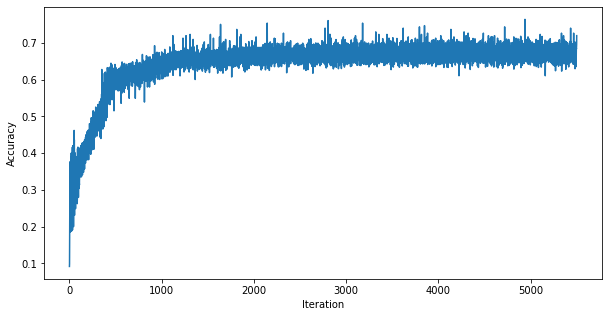

In [17]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

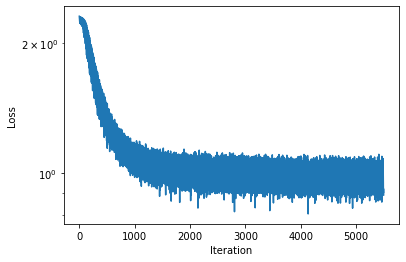

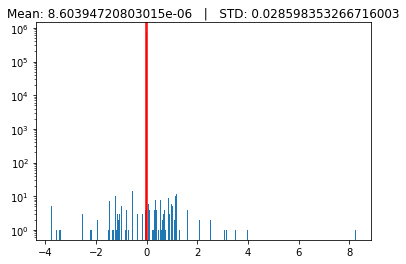

In [18]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 10.06060606060606


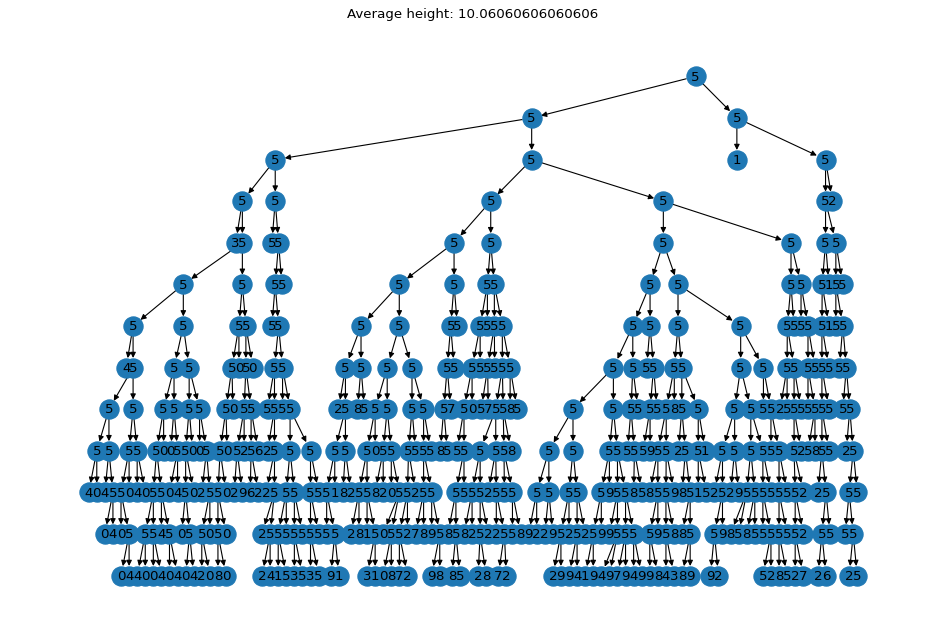

In [19]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [20]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 231


In [21]:
method = 'MLE'

In [22]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [23]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()